## 1. Preliminary

### 1.1 Context

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici [les données](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv) et [leur source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy). Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

<div class="alert alert-block alert-info">
Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
</div>

Vous cherchez également à **évaluer l’intérêt de l’"[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)" pour la prédiction d’émissions**, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
 1) Réaliser une courte analyse exploratoire.
 2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

> Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 
Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.


### 1.2 Requirements

In [1]:
package_list = ("pandas", "numpy", "matplotlib", "seaborn", "math", 
                "geopy", "scikit-learn", "folium")

In [2]:
!python3 -V

Python 3.10.13


In [3]:
txt = !python3 -m pip freeze
check = lambda i: any([(pack in i) for pack in package_list])
txt = [i for i in txt if check(i)]
txt

['folium==0.16.0',
 'geopy==2.4.1',
 'matplotlib==3.8.2',
 'matplotlib-inline==0.1.6',
 'mpmath @ file:///home/conda/feedstock_root/build_artifacts/mpmath_1678228039184/work',
 'numpy @ file:///Users/runner/miniforge3/conda-bld/numpy_1704280780572/work/dist/numpy-1.26.3-cp310-cp310-macosx_11_0_arm64.whl#sha256=f96d0b051b72345dbc317d793b2b34c7c4b7f41b0b791ffc93e820c45ba6a91c',
 'pandas==2.2.0',
 'scikit-learn==1.4.0',
 'seaborn==0.13.2']

### 1.3 Imports

In [4]:
# built in
import os

# data
import pandas as pd
import numpy as np
from math import ceil, floor, pow, sqrt
from geopy.distance import geodesic
import folium

# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# cross validation for KNN imputing
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### 1.4 Graphics and option

--

### 1.5 Data

In [5]:
# !tree -I 'mlruns|tries|*.png'

In [6]:
# os.listdir()

In [7]:
os.listdir('./data/source')

['.DS_Store', '2016_Building_Energy_Benchmarking.csv']

In [8]:
path = "./data/source/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [9]:
df0=pd.read_csv(path+filename)
df=df0.copy()
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

Les variables sont les suivantes : 


- **OSEBuildingID** : L'ID du batiment	
- **DataYear** : Année de consommation
- **BuildingType** : Type de Building (Résidence ou pas)
- **PrimaryPropertyType** : Type de propriété (Hotel, Ecole...)
- **PropertyName** : Nom du bâtiment
- **Address** : L'adresse du bâtiment
- **City** : La ville ou est situé le bâtiment
- **State** : L'état ou est situé le bâtiment
- **ZipCode** : Code postal (peut etre différent même dans un même état)
- **TaxParcelIdentificationNumber** : Numero identification (fiscale)
- **CouncilDistrictCode** : code du district du conseil de la ville de Seattle  
- **Neighborhood** : Quartier
- **Latitude** : La latitude
- **Longitude** : La longitude
- **YearBuilt** : Date de création ou de rénovation  
- **NumberofBuildings** : Nombre de buildings dans la propriété
- **NumberofFloors** : Nombre d'étages
- **PropertyGFATotal** : Surface brute de plancher totale du bâtiment et du parking 
- **PropertyGFAParking** : Espace brute de tous les types de stationnement  
- **PropertyGFABuilding(s)** : Surface brute du bâtiment  
- **ListOfAllPropertyUseTypes** : Types d'utilisation de la propriété  
- **LargestPropertyUseType** : Type d'utilisation principale de la propriété 
- **LargestPropertyUseTypeGFA** : Surface brute de plancher (Utilisation principale)
- **SecondLargestPropertyUseType** : Type d'utilisation secondaire de la propriété 
- **SecondLargestPropertyUseTypeGFA**: Surface brute de plancher (Utilisation secondaire) 
- **ThirdLargestPropertyUseType** : Type d'utilisation tertiaire de la propriété 
- **ThirdLargestPropertyUseTypeGFA** : Surface brute de plancher (Utilisation tertiaire) 
- **YearsENERGYSTARCertified** : Année auquel la propriété a recu la certification ENERGYSTAR
- **ENERGYSTARScore** : Score (de 1 a 100) qui calcule la performance énergétique d'un bien immobilier
- **SiteEUI(kBtu/sf)** : Energie annuelle consommée d'un bien immobilier / Surface brute de plancher
- **SiteEUIWN(kBtu/sf)** : SiteEUI(kBtu/sf) normalisée en fonctions des conditions météologiques
- **SourceEUI(kBtu/sf)** : Energie annuelle consommée d'un bien immobilier (y compris les pertes) / Surface brute de plancher
- **SourceEUIWN(kBtu/sf)** : SourceEUI(kBtu/sf) normalisée en fonctions des conditions météologiques
- **SiteEnergyUse(kBtu)** : Quantité annuelle d'énergie consommée, toutes sources d'énergie confondues
- **SiteEnergyUseWN(kBtu)** : SiteEnergyUse(kBtu) normalisée en fonctions des conditions météologiques
- **SteamUse(kBtu)** : Quantité annuelle de vapeur urbaine consommée
- **Electricity(kWh)** : Quantité annuelle d'électricité consommée
- **Electricity(kBtu)** : Electricity mais en British thermal units (kBtu)
- **NaturalGas(therms)** : Quantité annuelle de gaz naturel consommée (therms)
- **NaturalGas(kBtu)** : NaturalGas mais en British thermal units (kBtu).
- **DefaultData** : A t'on utilisé des valeurs par défault (fausses valeurs) sur certaines features?
- **Comments** : Commentaires du propriétaire ajoutant du contexte sur les valeurs des features
- **ComplianceStatus** : Satisfait t'il aux exigences de l'analyse de la consommation d'énergie?
- **Outlier** : Ce bâtiment est il dans la moyenne ou exceptionnel?
- **TotalGHGEmissions** : Quantité totale d'émissions de (dioxyde de carbone + le méthane + l'oxyde nitreux)
- **GHGEmissionsIntensity** : TotalGHGEmissions / Surface brute de plancher de la propriété

## 2. First Tour

### 2.1 Display

In [10]:
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [11]:
df.tail()

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
3371                Horticulture building  1600 S Dakota St  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  ...  Electricity(kWh)  \
3371      NaN                    1624049080  ...       153655.0000   
3372      NaN                    3558300000  ...       116221.0000   
3373      NaN                    1794501150  ...       525251.6875   
3374      NaN                    7883603155  ...       102248.0000   
3375      NaN                    7857002030  ...       126774.3984   

     Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3371      5.242709e+05         3254.750244      3.254750e+05         True   
3372      3.965461e+05         5537.299805      5.537300e+05        False   
3373      1.792159e+06        39737.390630      3.973739e+06        False   
3374      3.488702e+05         3706.010010      3.706010e+05        False   
3375      4.325542e+05         7203.419922      7.203420e+05        False   

      Comments              ComplianceStatus  Outlier  TotalGHGEmissions  \
3371       NaN  Error - Correct Default Data      NaN              20.94   
3372       NaN                     Compliant      NaN              32.17   
3373       NaN                     Compliant      NaN             223.54   
3374       NaN                     Compliant      NaN              22.11   
3375       NaN                     Compliant      NaN              41.27   

      GHGEmissionsIntensity  
3371                   1.70  
3372                   2.01  
3373                  16.99  
3374                   1.57  
3375                   2.26  

[5 rows x 46 columns]

In [12]:
df.sample(5)

OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
124             198      2016        NonResidential              Hospital   
1046          20618      2016        NonResidential             Warehouse   
647           19453      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
2128          24544      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
2342          25325      2016        NonResidential      Worship Facility   

                                 PropertyName                 Address  \
124   Seattle Children's Hospital Main Campus  4800 Sand Point Way NE   
1046                  Compton Lumber Co., Inc  3847  1st Avenue South   
647                 Lakeview Court Apartments         1901 NE 85th ST   
2128                              Pomeroy-335            2319 1st AVE   
2342            All Pilgrims Christian Church          500 Broadway E   

         City State  ZipCode TaxParcelIdentificationNumber  ...  \
124   Seattle    WA  98105.0                    2982800005  ...   
1046  Seattle    WA  98134.0                    1824049075  ...   
647   Seattle    WA  98115.0                    0425049010  ...   
2128  Seattle    WA  98121.0                    6839900000  ...   
2342  Seattle    WA  98102.0                    6852700670  ...   

      Electricity(kWh) Electricity(kBtu)  NaturalGas(therms)  \
124       3.389250e+07       115641210.0        1.381912e+06   
1046      1.854360e+05          632708.0        1.193860e+03   
647       5.106539e+05         1742351.0        0.000000e+00   
2128      7.679830e+05         2620358.0        1.431567e+04   
2342      6.546750e+04          223375.0        4.965300e+03   

      NaturalGas(kBtu)  DefaultData  Comments  ComplianceStatus  Outlier  \
124        138191238.0        False       NaN         Compliant      NaN   
1046          119386.0        False       NaN         Compliant      NaN   
647                0.0        False       NaN         Compliant      NaN   
2128         1431567.0        False       NaN         Compliant      NaN   
2342          496530.0        False       NaN         Compliant      NaN   

      TotalGHGEmissions  GHGEmissionsIntensity  
124             8145.52                   9.27  
1046              10.75                   0.28  
647               12.15                   0.16  
2128              94.30                   1.07  
2342              27.93                   1.06  

[5 rows x 46 columns]

### 2.2 Structure

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [14]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [15]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


### 2.3 Nan & duplicated

In [16]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [17]:
df.duplicated().sum()

0

In [18]:
df.drop(columns="ENERGYSTARScore").duplicated().sum()

0

### 2.4 Data inspection

In [19]:
df.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  ...  SiteEnergyUse(kBtu)  \
count     3376.000000      3.376000e+03  ...         3.371000e+03   
mean         4.709123      9.483354e+04  ...         5.403667e+06   
std          5.494465      2.188376e+05  ...         2.161063e+07   
min          0.000000      1.128500e+04  ...         0.000000e+00   
25%          2.000000      2.848700e+04  ...         9.251286e+05   
50%          4.000000      4.417500e+04  ...         1.803753e+06   
75%          5.000000      9.099200e+04  ...         4.222455e+06   
max         99.000000      9.320156e+06  ...         8.739237e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           3.370000e+03    3.367000e+03      3.367000e+03   
mean            5.276726e+06    2.745959e+05      1.086639e+06   
std             1.593879e+07    3.912173e+06      4.352478e+06   
min             0.000000e+00    0.000000e+00     -3.382680e+04   
25%             9.701822e+05    0.000000e+00      1.874229e+05   
50%             1.904452e+06    0.000000e+00      3.451299e+05   
75%             4.381429e+06    0.000000e+00      8.293178e+05   
max             4.716139e+08    1.349435e+08      1.925775e+08   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  Comments  \
count       3.367000e+03        3.367000e+03      3.367000e+03       0.0   
mean        3.707612e+06        1.368505e+04      1.368505e+06       NaN   
std         1.485066e+07        6.709781e+04      6.709781e+06       NaN   
min        -1.154170e+05        0.000000e+00      0.000000e+00       NaN   
25%         6.394870e+05        0.000000e+00      0.000000e+00       NaN   
50%         1.177583e+06        3.237538e+03      3.237540e+05       NaN   
75%         2.829632e+06        1.189033e+04      1.189034e+06       NaN   
max         6.570744e+08        2.979090e+06      2.979090e+08       NaN   

       TotalGHGEmissions  GHGEmissionsIntensity  
count        3367.000000            3367.000000  
mean          119.723971               1.175916  
std           538.832227               1.821452  
min            -0.800000              -0.020000  
25%             9.495000               0.210000  
50%            33.920000               0.610000  
75%            93.940000               1.370000  
max         16870.980000              34.090000  

[8 rows x 30 columns]

Let's inspect the EnergyStarScore

In [20]:
df.ENERGYSTARScore.value_counts()

ENERGYSTARScore
100.0    109
98.0      72
96.0      64
89.0      58
93.0      57
        ... 
36.0       8
35.0       8
22.0       8
9.0        5
4.0        5
Name: count, Length: 100, dtype: int64

In [21]:
df['ENERGYSTARScore'].value_counts(normalize=True).round(2)

ENERGYSTARScore
100.0    0.04
98.0     0.03
96.0     0.03
89.0     0.02
93.0     0.02
         ... 
36.0     0.00
35.0     0.00
22.0     0.00
9.0      0.00
4.0      0.00
Name: proportion, Length: 100, dtype: float64

In [22]:
df['ENERGYSTARScore'].value_counts(normalize=True).sum()

1.0

<Axes: ylabel='count'>

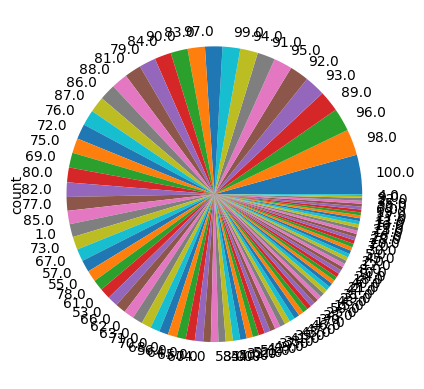

In [23]:
df.ENERGYSTARScore.value_counts().plot(kind="pie")

<Axes: ylabel='count'>

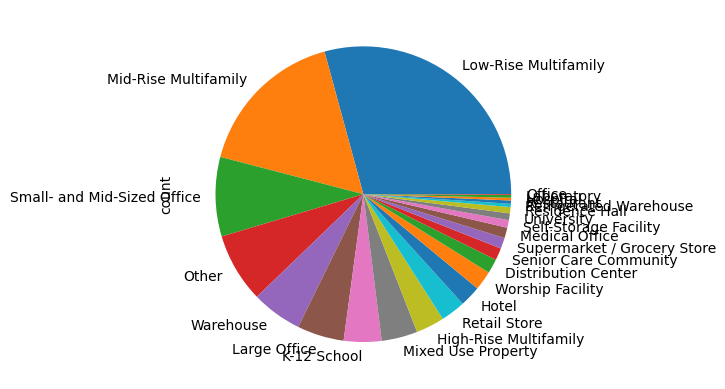

In [24]:
df.PrimaryPropertyType.value_counts().plot(kind="pie")

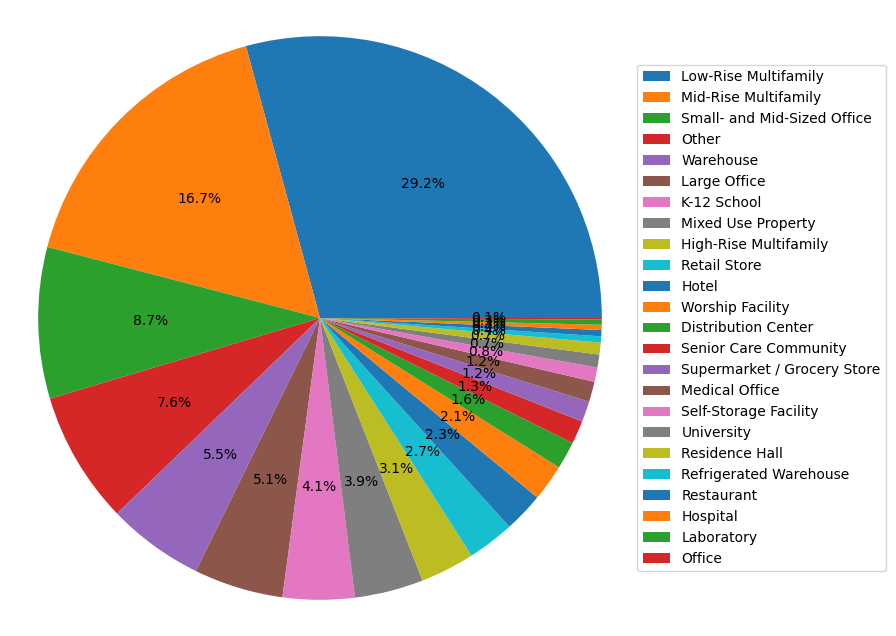

In [25]:
# Calculer les comptes des valeurs de la colonne 'PrimaryPropertyType'
value_counts = df.PrimaryPropertyType.value_counts()

# Créer un pie plot avec pourcentages et ajustement de la taille de la figure
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(value_counts, autopct='%1.1f%%')

# Ajuster le cercle pour qu'il soit bien proportionné
plt.axis('equal')

# Définir la position de la légende en dehors du plot
plt.legend(patches, value_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))

# Afficher le pie plot
plt.show()


Visualisons valeurs manquantes

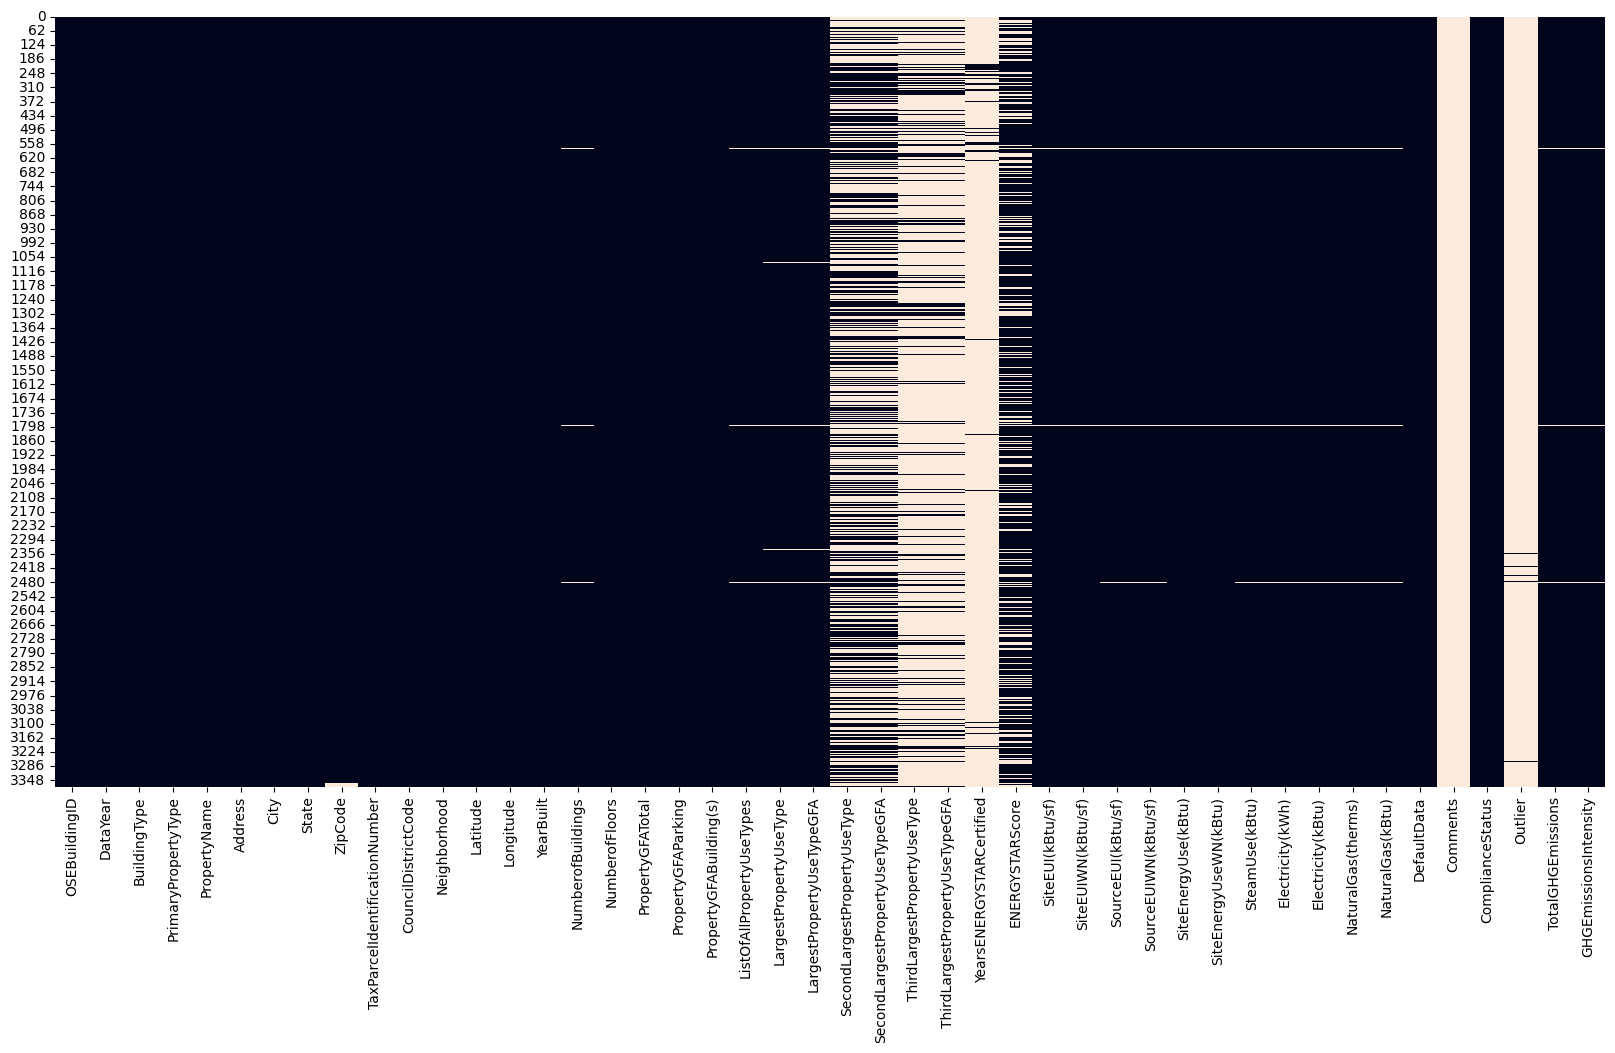

In [26]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)
plt.show()

Définissons des fonctions pour visualiser les données

In [27]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
def get_colors_from_listedcolormap(colormap, num_colors):
    """
    Génère une liste de couleurs à partir d'une colormap avec un espacement homogène.

    Args:
    colormap: Une colormap de seaborn ou matplotlib.
    num_colors: Le nombre de couleurs à extraire.

    Returns:
    List: Une liste contenant les couleurs extraites.
    """
    if num_colors < 2:
        return [colormap.colors[0]]

    step = (colormap.N - 1) / (num_colors - 1)
    return [colormap.colors[floor(i * step)] for i in range(num_colors)]

def get_set_of_labels(dataframe, dtype):
    """
    Retourne un ensemble de labels de colonnes d'un DataFrame qui correspondent à un dtype spécifique.

    Args:
    dataframe: DataFrame pandas à analyser.
    dtype: Le type de données (par exemple 'float64', 'int64').

    Returns:
    Set: Un ensemble contenant les labels des colonnes.
    """
    return {label for label, dt in dataframe.dtypes.items() if dt == dtype}

def plot_sghisto(dataframe, dtype, color='', max_items=100, labels=None, title=''):
    """
    Génère une grille carrée d'histogrammes pour chaque variable d'un certain type dans un DataFrame.

    Args:
    dataframe: Le DataFrame pandas contenant les données.
    dtype: Le type de données des colonnes à représenter ('all', 'numbers', ou un dtype spécifique).
    color: Couleur des histogrammes.
    max_items: Nombre maximal d'éléments à afficher pour les données catégorielles.
    labels: Labels des colonnes à inclure dans les histogrammes. Si None, déterminé automatiquement.
    title: Titre de la grille d'histogrammes.
    """
    if labels is None:
        if dtype == 'all':
            labels = dataframe.columns.values
        elif dtype == 'numbers':
            labels = get_set_of_labels(dataframe, 'float64').union(get_set_of_labels(dataframe, 'int64'))
        else:
            labels = get_set_of_labels(dataframe, dtype)

    num_labels = len(labels)
    grid_size = ceil(sqrt(num_labels))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(30, 30))
    fig.suptitle(title, fontsize=32, x=0.5, y=0.95)

    for i, label in enumerate(labels):
        ax = axs[floor(i / grid_size), i % grid_size]
        if dataframe[label].dtype == 'object':
            df_temp = dataframe[label].value_counts().iloc[:max_items]
            sns.histplot(data=dataframe[dataframe[label].isin(df_temp.index)], x=label, color=color, discrete=True, ax=ax)
        else:
            sns.histplot(data=dataframe, x=label, color=color, ax=ax)
        ax.set_xlabel(f'{label[:15]}', fontdict={'fontsize': 18})
        ax.set_ylabel('')

    # Supprimer les axes excédentaires
    for i in range(num_labels, grid_size ** 2):
        axs.flatten()[i].remove()

# Configuration des couleurs
COLORMAP = sns.color_palette("plasma", as_cmap=True)
COLORS = get_colors_from_listedcolormap(COLORMAP, 5)
COLOR_PRIMARY, COLOR_SECONDARY, COLOR_TERTIARY, COLOR_QUATERNARY, COLOR_QUINARY = COLORS


Distribution des valeurs quantitatives et qualitatives

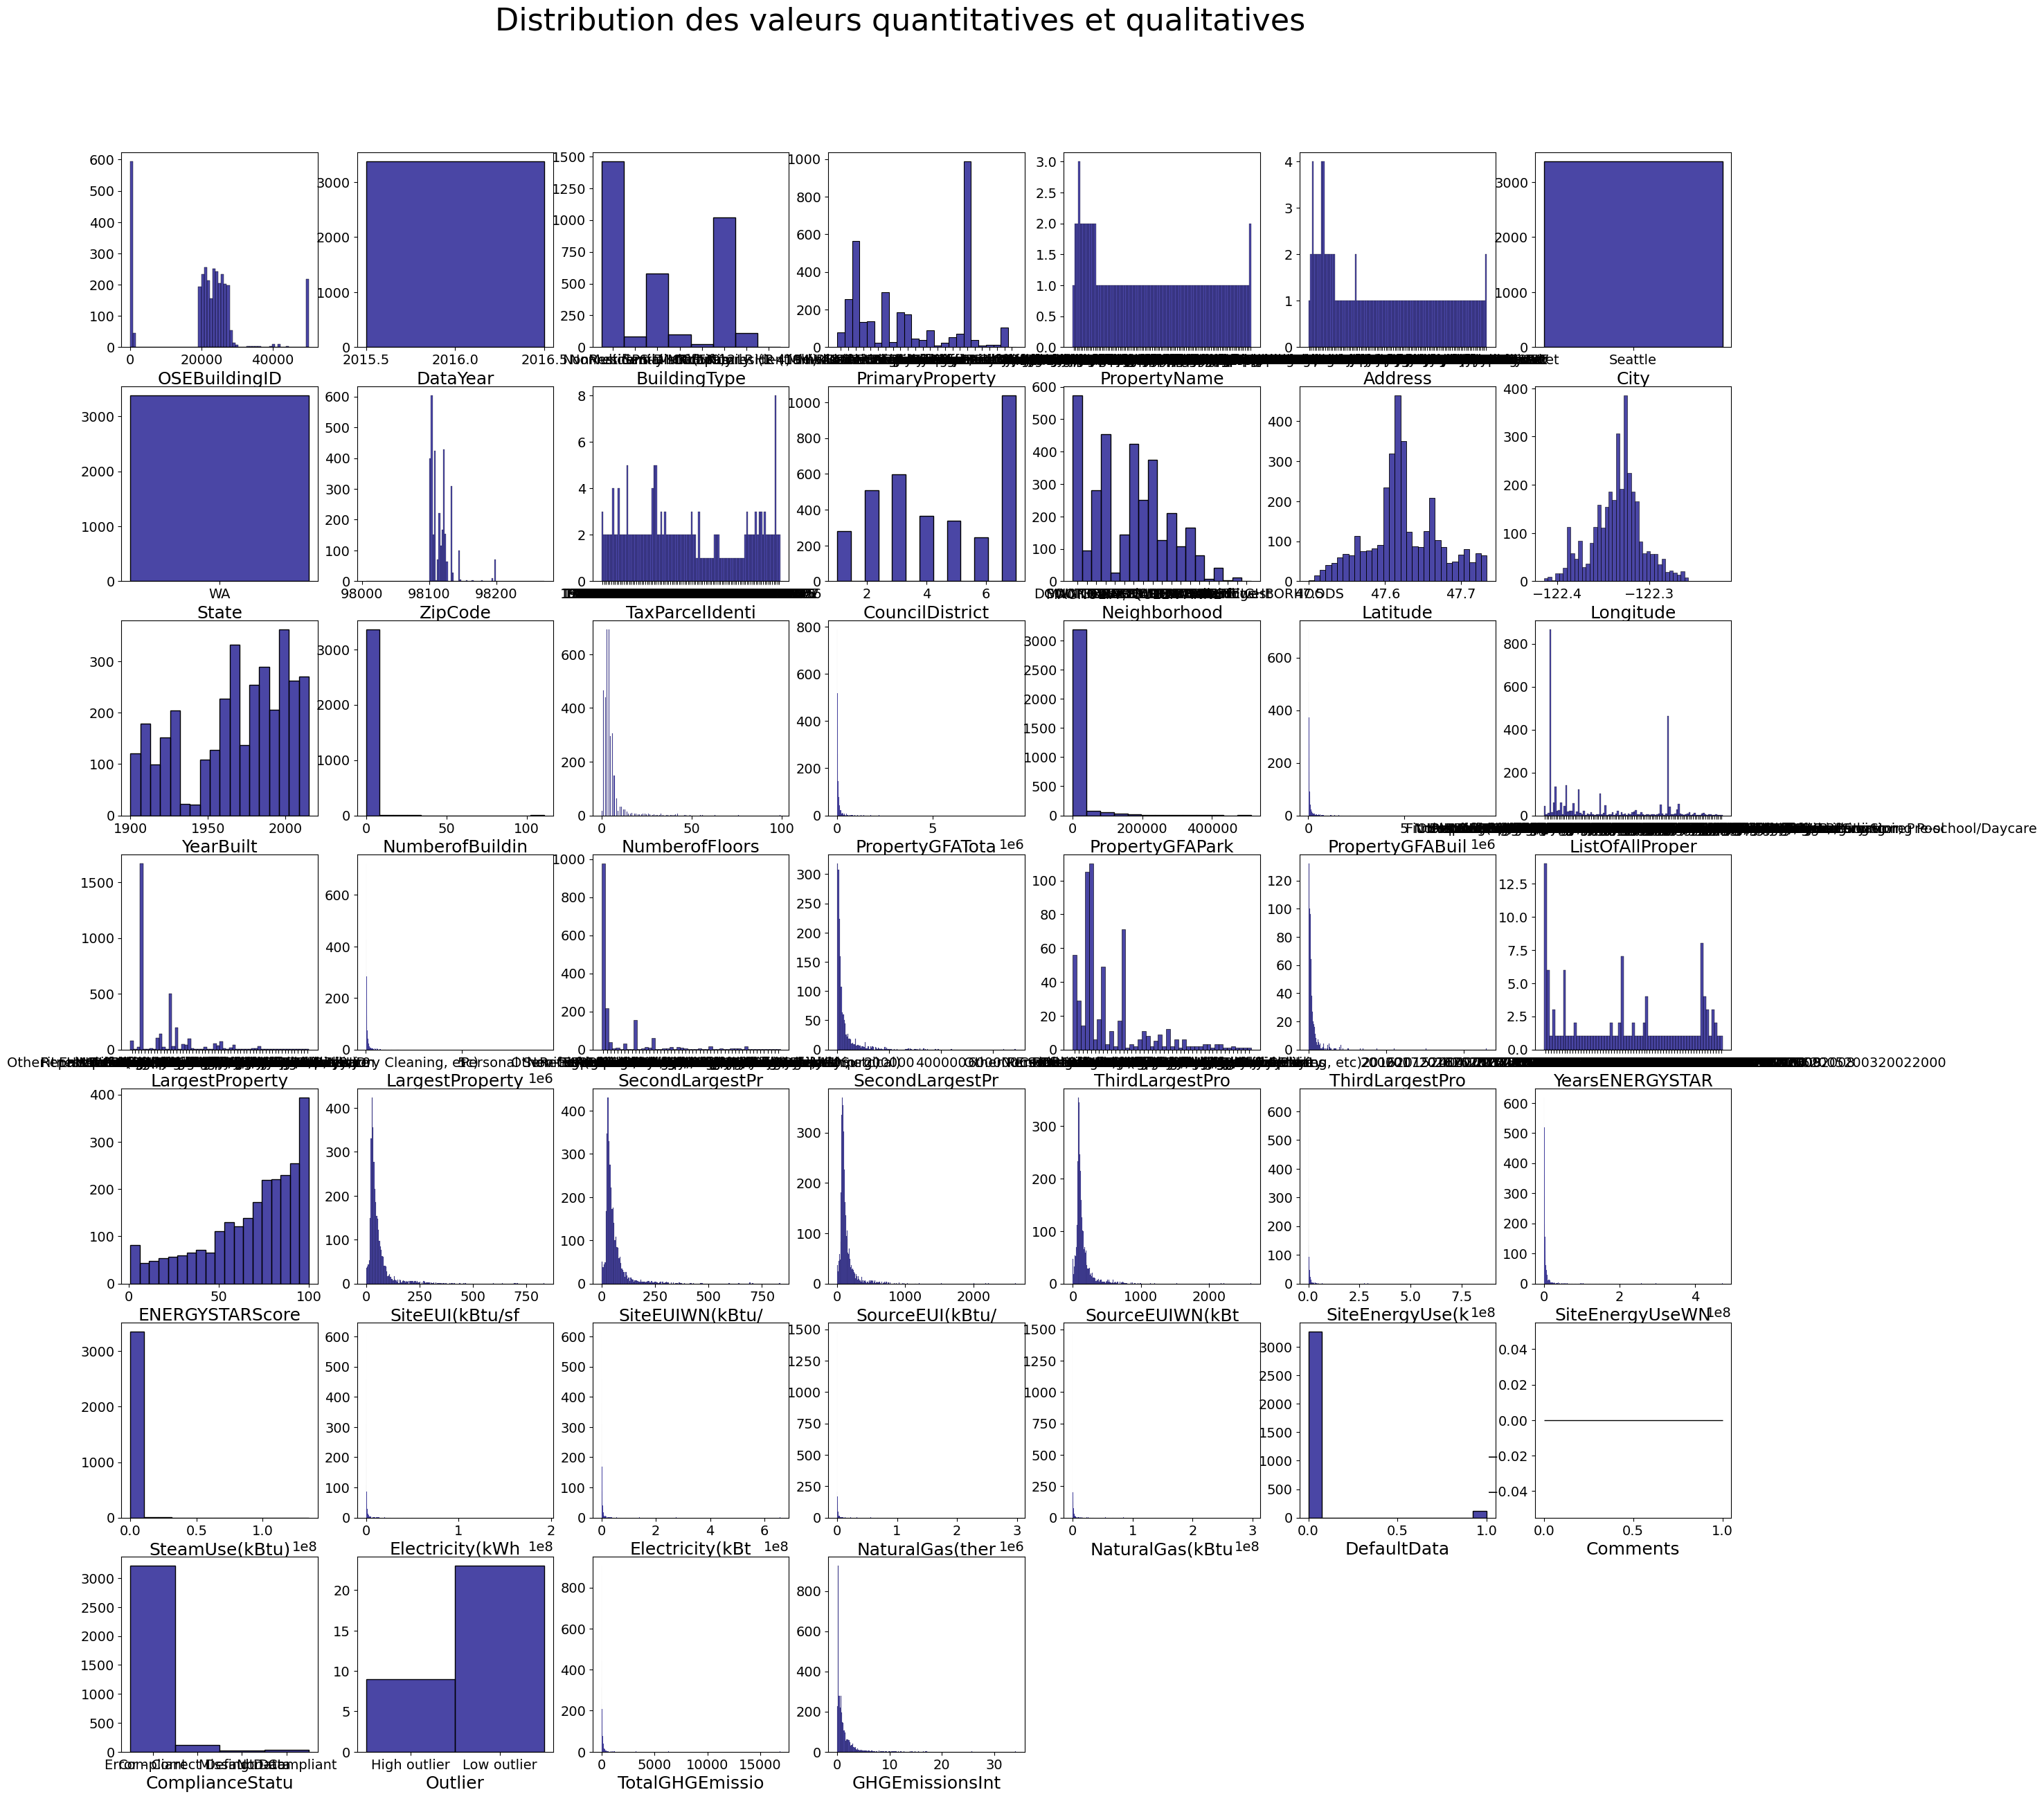

In [29]:
plot_sghisto(df, dtype='all', title='Distribution des valeurs quantitatives et qualitatives', color=COLOR_PRIMARY)

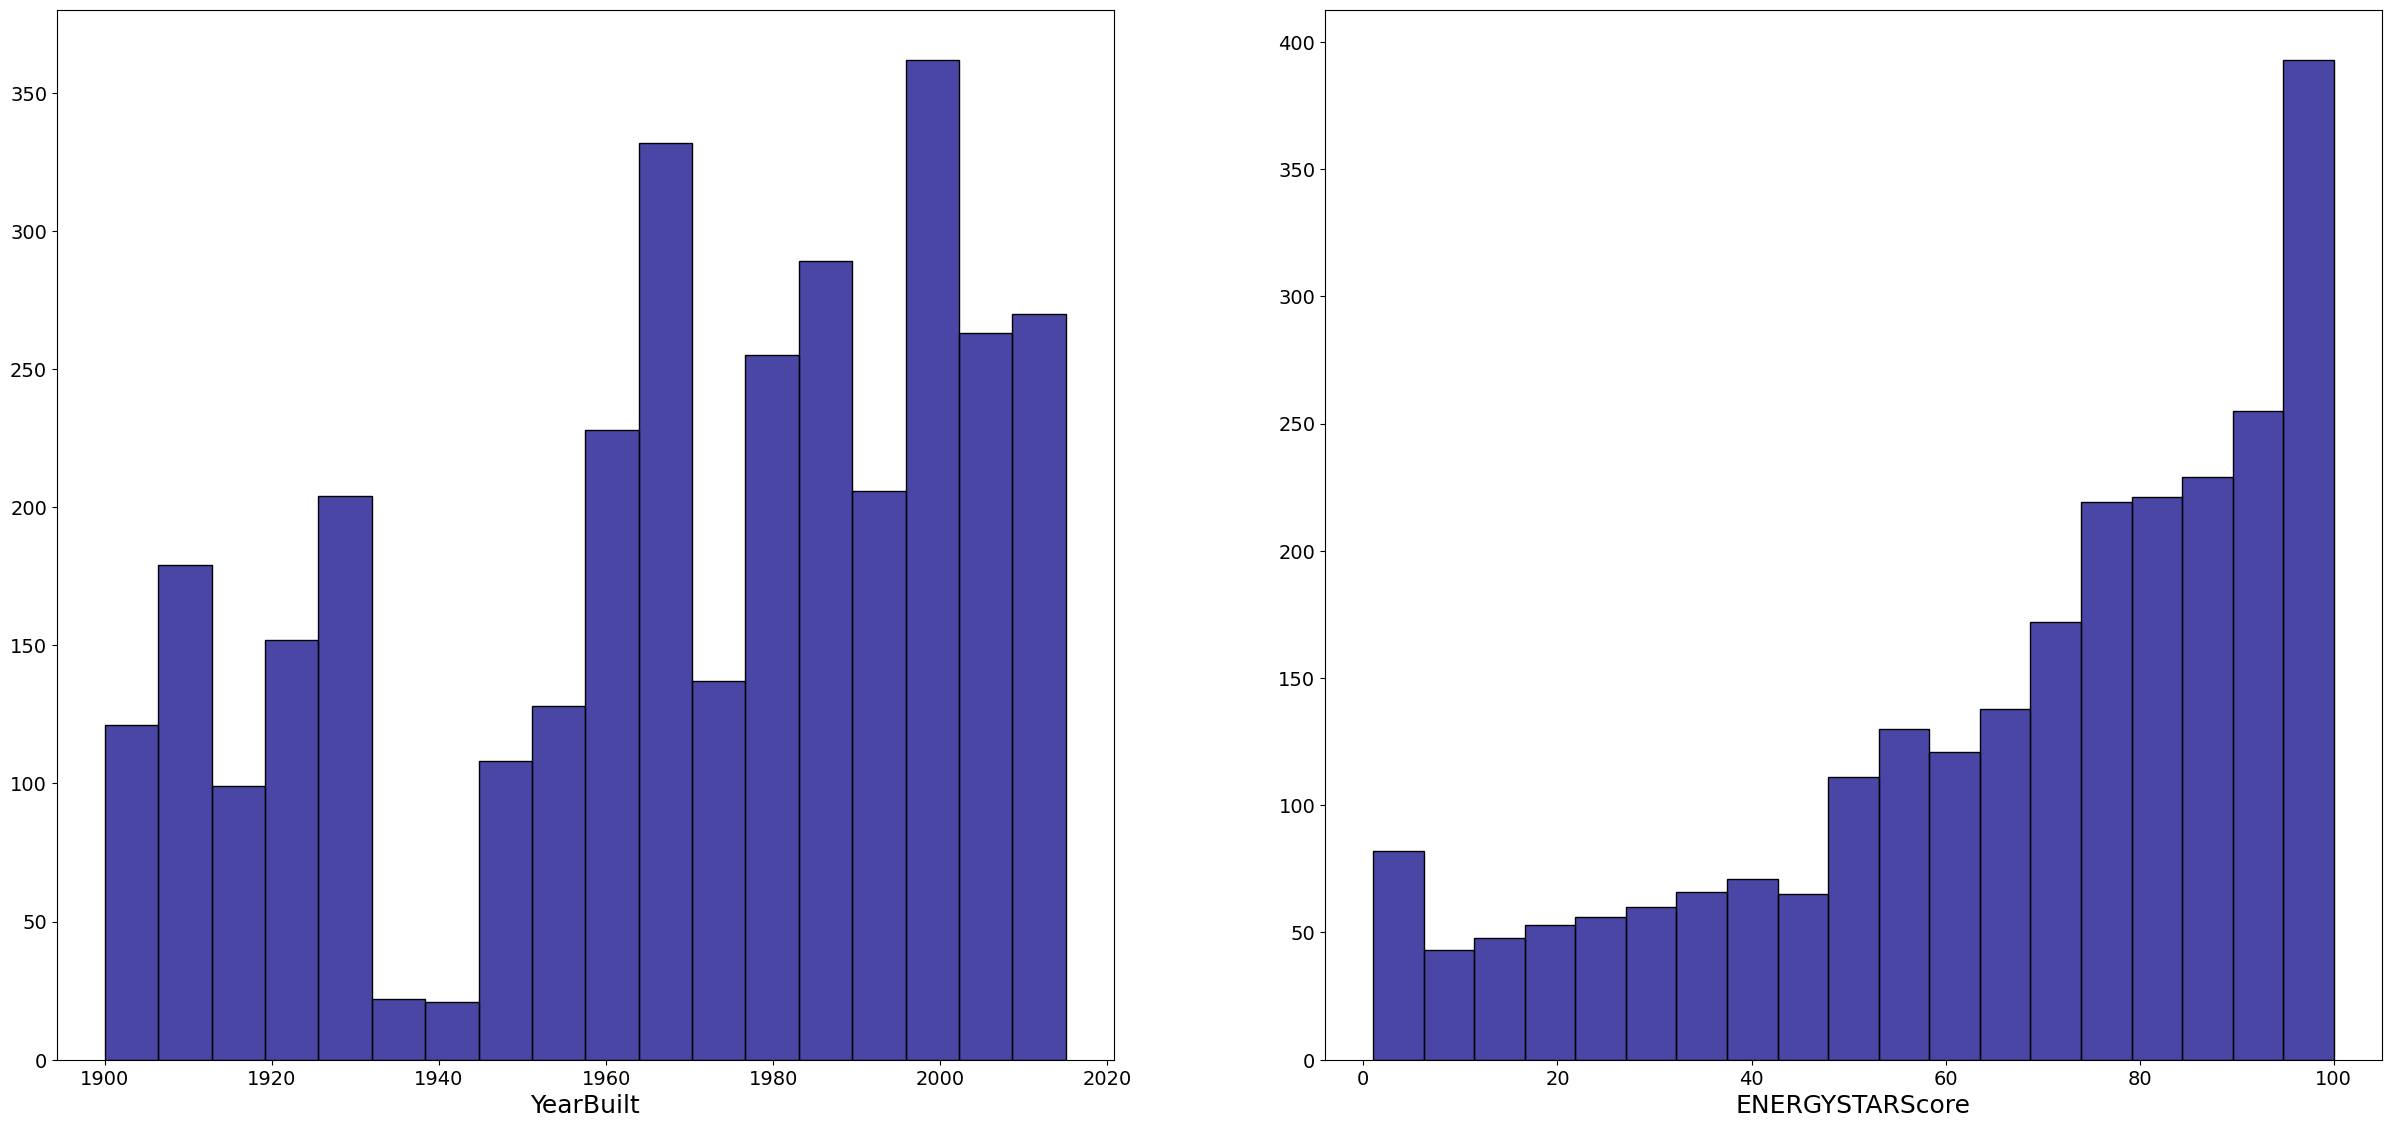

In [30]:
plot_sghisto(df[['YearBuilt', 'ENERGYSTARScore']], dtype='all', title='', color=COLOR_PRIMARY)

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def boxplot_columns(dataframe, columns):
    """
    Generate boxplots for specified columns of a dataframe.

    Parameters:
    dataframe (DataFrame): The pandas DataFrame containing the data.
    columns (list): A list of column names for which boxplots are to be generated.
    """
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input 'dataframe' must be a pandas DataFrame.")
    
    if not isinstance(columns, list):
        raise ValueError("Input 'columns' must be a list of column names.")
    
    for column in columns:
        if column not in dataframe.columns:
            print(f"Column '{column}' not found in the dataframe.")
            continue
        
        # Filter out NaN values
        column_data = dataframe[column].dropna()
        
        # Check if there are any data points left after dropping NaNs
        if column_data.empty:
            print(f"No data points available for column '{column}'.")
            continue
        
        # Plot the boxplot
        plt.figure(figsize=(8, 6))
        plt.boxplot(column_data)
        plt.title(f'Boxplot of {column}')
        # plt.xlabel('Value')
        plt.ylabel('Value')
        plt.show()

# Example usage:
# Suppose 'df' is your dataframe
# boxplot_columns(df, ['Column1', 'Column2', 'Column3'])


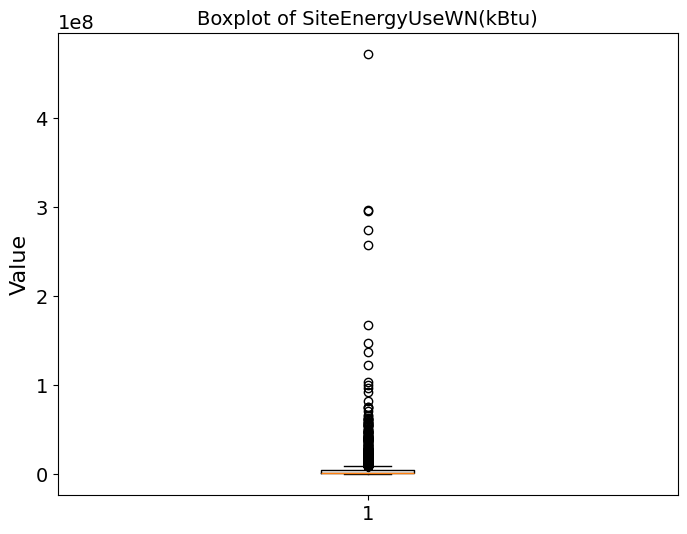

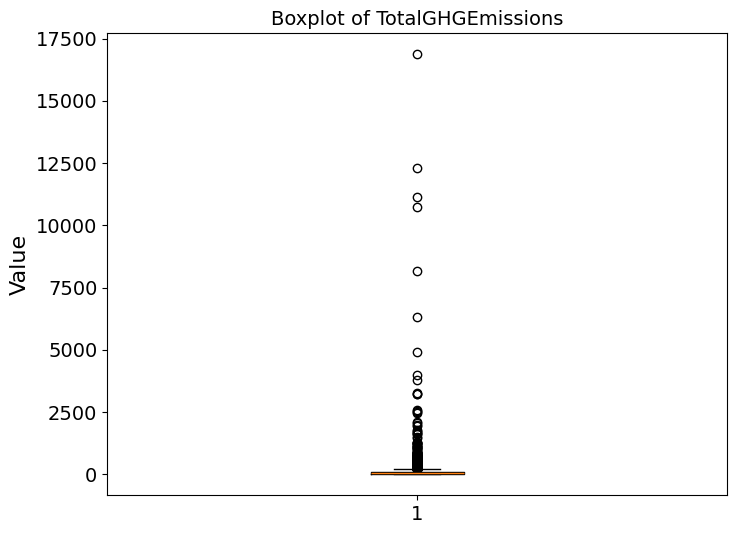

In [32]:
# boxplot_columns(df, ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])
boxplot_columns(df, ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])

In [33]:
def detect_outliers_iqr(dataframe, column):
    """
    Detect outliers in a specific column of a dataframe using the interquartile range (IQR) method.

    Parameters:
    dataframe (DataFrame): The pandas DataFrame containing the data.
    column (str): The name of the column for which outliers are to be detected.

    Returns:
    DataFrame: A subset of the original dataframe containing only the rows with outliers.
    """
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input 'dataframe' must be a pandas DataFrame.")
    
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in the dataframe.")
    
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 50 * IQR
    upper_bound = Q3 + 50 * IQR
    
    # Detect outliers
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    
    return outliers

# Example usage:
# Suppose 'df' is your dataframe and 'column_name' is the name of the column with outliers
# outliers_df = detect_outliers_iqr(df, 'column_name')
# print(outliers_df)


In [34]:
# boxplot_columns(df, ['SteamUse(kBtu)', 'Electricity(kBtu)', 
# 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])
pd.set_option('display.max_columns', None)

outliers_df = detect_outliers_iqr(df, 'TotalGHGEmissions')
outliers_df.head(10)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
35               43      2016          Campus  Mixed Use Property   
124             198      2016  NonResidential            Hospital   
167             268      2016  NonResidential            Hospital   
170             276      2016  NonResidential            Hospital   
618             828      2016  NonResidential            Hospital   
3264          49940      2016  NonResidential            Hospital   
3274          49967      2016          Campus          University   

                                   PropertyName                    Address  \
35                                 Plant 2 Site      7755 E MARGINAL WAY S   
124     Seattle Children's Hospital Main Campus     4800 Sand Point Way NE   
167                         Swedish Cherry Hill               500 17th Ave   
170                   Harborview Medical Center               325 9th Ave.   
618                          Swedish First Hill               747 Broadway   
3264       Virginia Mason Medical Center - 2149             925 Seneca St.   
3274  University of Washington - Seattle Campus  NE 45th St & Brooklyn Ave   

         City State  ZipCode TaxParcelIdentificationNumber  \
35    Seattle    WA  98108.0                    0022000005   
124   Seattle    WA  98105.0                    2982800005   
167   Seattle    WA  98122.0                    7942600331   
170   Seattle    WA  98104.0                    8590900220   
618   Seattle    WA  98122.0                    1978201096   
3264  Seattle    WA  98101.0                    1979200210   
3274  Seattle    WA  98105.0                    1625049001   

      CouncilDistrictCode      Neighborhood   Latitude   Longitude  YearBuilt  \
35                      2  GREATER DUWAMISH  47.534930 -122.317880       1992   
124                     4         NORTHEAST  47.662310 -122.281460       1953   
167                     3           CENTRAL  47.607050 -122.309660       1990   
170                     3              EAST  47.603990 -122.323770       2000   
618                     3              EAST  47.608951 -122.322402       1994   
3264                    3              EAST  47.609860 -122.327740       1920   
3274                    4         NORTHEAST  47.656440 -122.310410       1900   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
35                  1.0               3            494835                   0   
124                 6.0              10            879000                   0   
167                 6.0               5            597519                   0   
170                 9.0               8           1158691                   0   
618                 7.0              14           1765970                   0   
3264                1.0               8            374466                   0   
3274              111.0               0           9320156                   0   

      PropertyGFABuilding(s)  \
35                    494835   
124                   879000   
167                   597519   
170                  1158691   
618                  1765970   
3264                  374466   
3274                 9320156   

                              ListOfAllPropertyUseTypes  \
35    Energy/Power Station, Laboratory, Manufacturin...   
124               Hospital (General Medical & Surgical)   
167      Hospital (General Medical & Surgical), Parking   
170      Hospital (General Medical & Surgical), Parking   
618      Hospital (General Medical & Surgical), Parking   
3264              Hospital (General Medical & Surgical)   
3274                                 College/University   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
35                                   Office                   757027.0   
124   Hospital (General Medical & Surgical)                   879000.0   
167   Hospital (General Medical & Surgical)                   601615.0   
170   H

In [35]:
# boxplot_columns(df, ['SteamUse(kBtu)', 'Electricity(kBtu)', 
# 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])

outliers_df = detect_outliers_iqr(df, 'SiteEnergyUseWN(kBtu)')
outliers_df.head(10)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
35              43      2016          Campus  Mixed Use Property   
124            198      2016  NonResidential            Hospital   
170            276      2016  NonResidential            Hospital   
558            753      2016  NonResidential               Other   
618            828      2016  NonResidential            Hospital   

                                PropertyName                 Address     City  \
35                              Plant 2 Site   7755 E MARGINAL WAY S  Seattle   
124  Seattle Children's Hospital Main Campus  4800 Sand Point Way NE  Seattle   
170                Harborview Medical Center            325 9th Ave.  Seattle   
558                           WestinBuilding            2001 6th Ave  Seattle   
618                       Swedish First Hill            747 Broadway  Seattle   

    State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
35     WA  98108.0                    0022000005                    2   
124    WA  98105.0                    2982800005                    4   
170    WA  98104.0                    8590900220                    3   
558    WA  98121.0                    0659000950                    7   
618    WA  98122.0                    1978201096                    3   

         Neighborhood   Latitude   Longitude  YearBuilt  NumberofBuildings  \
35   GREATER DUWAMISH  47.534930 -122.317880       1992                1.0   
124         NORTHEAST  47.662310 -122.281460       1953                6.0   
170              EAST  47.603990 -122.323770       2000                9.0   
558          DOWNTOWN  47.614380 -122.338710       1981                1.0   
618              EAST  47.608951 -122.322402       1994                7.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
35                3            494835                   0   
124              10            879000                   0   
170               8           1158691                   0   
558              33            429405                   0   
618              14           1765970                   0   

     PropertyGFABuilding(s)  \
35                   494835   
124                  879000   
170                 1158691   
558                  429405   
618                 1765970   

                             ListOfAllPropertyUseTypes  \
35   Energy/Power Station, Laboratory, Manufacturin...   
124              Hospital (General Medical & Surgical)   
170     Hospital (General Medical & Surgical), Parking   
558                                Data Center, Office   
618     Hospital (General Medical & Surgical), Parking   

                    LargestPropertyUseType  LargestPropertyUseTypeGFA  \
35                                  Office                   757027.0   
124  Hospital (General Medical & Surgical)                   879000.0   
170  Hospital (General Medical & Surgical)                  1350182.0   
558                            Data Center                   218997.0   
618  Hospital (General Medical & Surgical)                  1639334.0   

    SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
35                    Laboratory                         639931.0   
124                          NaN                              NaN   
170                      Parking                         387651.0   
558                       Office                         210409.0   
618                      Parking                         441551.0   

    ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
35   Non-Refrigerated Warehouse                        459748.0   
124                         NaN                             NaN   
170                         NaN                             NaN   
558                         NaN                             NaN   
618                         NaN                             NaN   

    YearsENERGYSTARCertified  ENERGYSTARS

In [36]:
# Afficher la valeur de la colonne 'Address' de la ligne avec l'index 558
address_value = df.loc[558, 'Address']
print(address_value)

2001 6th Ave


Comparaison de la somme des surface de parkin et des batiments avc la surface totale

In [37]:
# Comparez PropertyGFATotal avec la somme de PropertyGFAParking et PropertyGFABuilding(s)
df['Comparison_Result'] = df['PropertyGFATotal'] == df['PropertyGFAParking'] + df['PropertyGFABuilding(s)']

print(df['Comparison_Result'])

# Comptez le nombre de True et de False dans la colonne Comparison_Result
result_counts = df['Comparison_Result'].value_counts()

print(result_counts)

0       True
1       True
2       True
3       True
4       True
        ... 
3371    True
3372    True
3373    True
3374    True
3375    True
Name: Comparison_Result, Length: 3376, dtype: bool
Comparison_Result
True    3376
Name: count, dtype: int64


In [38]:
df = df.drop(columns='Comparison_Result')

## 3. Cleaning

In [39]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### 3.1 Suppression des colonnes à valeur unique et des colonnes avec +50% NaN

In [41]:
count_unique = df.nunique()

# Filtrer les colonnes avec une seule valeur unique
columns_with_single_value = count_unique[count_unique == 1].index.tolist()

# Afficher les noms des colonnes avec leur valeur unique
for column in columns_with_single_value:
    unique_value = df[column].unique()[0]
    print(f"Colonne : {column}, Valeur unique : {unique_value}")


print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=columns_with_single_value)
print("Nombre de colonnes après la suppression :", df.shape[1])

Colonne : DataYear, Valeur unique : 2016
Colonne : City, Valeur unique : Seattle
Colonne : State, Valeur unique : WA
Nombre de colonnes avant la suppression : 46
Nombre de colonnes après la suppression : 43


In [42]:
# Calculer le pourcentage de NaN par colonne
pourcentage_nan = df.isna().mean()

# Filtrer les colonnes ayant plus de 50% de NaN
colonnes_a_supprimer = pourcentage_nan[pourcentage_nan > 0.5].index

pourcentage_nan


OSEBuildingID                      0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
ZipCode                            0.004739
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.002370
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.002666
LargestPropertyUseType             0.005924
LargestPropertyUseTypeGFA          0.005924
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType     

In [43]:
colonnes_a_supprimer

Index(['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'Comments', 'Outlier'],
      dtype='object')

In [44]:
# Supprimer ces colonnes du DataFrame
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=colonnes_a_supprimer)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 43
Nombre de colonnes après la suppression : 36


### 3.2 Séparation en df cat et df num

In [45]:
# Séparer les variables catégorielles
df_cat = df.select_dtypes(include=['object', 'category'])

# Séparer les variables numériques
df_num = df.select_dtypes(include=[np.number])  # np.number couvre int, float, etc.

In [46]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BuildingType                   3376 non-null   object
 1   PrimaryPropertyType            3376 non-null   object
 2   PropertyName                   3376 non-null   object
 3   Address                        3376 non-null   object
 4   TaxParcelIdentificationNumber  3376 non-null   object
 5   Neighborhood                   3376 non-null   object
 6   ListOfAllPropertyUseTypes      3367 non-null   object
 7   LargestPropertyUseType         3356 non-null   object
 8   ComplianceStatus               3376 non-null   object
dtypes: object(9)
memory usage: 237.5+ KB


In [47]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              3376 non-null   int64  
 1   ZipCode                    3360 non-null   float64
 2   CouncilDistrictCode        3376 non-null   int64  
 3   Latitude                   3376 non-null   float64
 4   Longitude                  3376 non-null   float64
 5   YearBuilt                  3376 non-null   int64  
 6   NumberofBuildings          3368 non-null   float64
 7   NumberofFloors             3376 non-null   int64  
 8   PropertyGFATotal           3376 non-null   int64  
 9   PropertyGFAParking         3376 non-null   int64  
 10  PropertyGFABuilding(s)     3376 non-null   int64  
 11  LargestPropertyUseTypeGFA  3356 non-null   float64
 12  ENERGYSTARScore            2533 non-null   float64
 13  SiteEUI(kBtu/sf)           3369 non-null   float

### 3.3 Nettoyage de df_cat

In [48]:
df_cat[['Neighborhood']].head()

Neighborhood
0     DOWNTOWN
1     DOWNTOWN
2     DOWNTOWN
3     DOWNTOWN
4     DOWNTOWN

In [49]:
np.unique(df_cat[['Neighborhood']])

array(['BALLARD', 'Ballard', 'CENTRAL', 'Central', 'DELRIDGE',
       'DELRIDGE NEIGHBORHOODS', 'DOWNTOWN', 'Delridge', 'EAST',
       'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH',
       'NORTHEAST', 'NORTHWEST', 'North', 'Northwest', 'SOUTHEAST',
       'SOUTHWEST'], dtype=object)

In [50]:
# Assuming df_cat is your DataFrame
df_cat['Neighborhood'] = df_cat['Neighborhood'].str.upper()

# Now checking the unique values
unique_neighborhoods = np.unique(df_cat[['Neighborhood']])
print(unique_neighborhoods)

['BALLARD' 'CENTRAL' 'DELRIDGE' 'DELRIDGE NEIGHBORHOODS' 'DOWNTOWN' 'EAST'
 'GREATER DUWAMISH' 'LAKE UNION' 'MAGNOLIA / QUEEN ANNE' 'NORTH'
 'NORTHEAST' 'NORTHWEST' 'SOUTHEAST' 'SOUTHWEST']


In [51]:
# Replace 'DELRIDGE NEIGHBORHOODS' with 'DELRIDGE'
df_cat['Neighborhood'] = df_cat['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

# Check the updated unique values
updated_unique_neighborhoods = np.unique(df_cat[['Neighborhood']])
print(updated_unique_neighborhoods)


['BALLARD' 'CENTRAL' 'DELRIDGE' 'DOWNTOWN' 'EAST' 'GREATER DUWAMISH'
 'LAKE UNION' 'MAGNOLIA / QUEEN ANNE' 'NORTH' 'NORTHEAST' 'NORTHWEST'
 'SOUTHEAST' 'SOUTHWEST']


In [52]:
# Afficher les valeurs uniques
print(df_cat['BuildingType'].unique())

# Compter les occurrences des valeurs uniques
print(df_cat['BuildingType'].value_counts())

['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64


- **NonResidential**: Il s'agit d'un type de bâtiment qui n'est pas résidentiel
- **Nonresidential COS**: "Commercial/Office Space" (espace commercial/bureaux)
- **Multifamily MR**: Bâtiments résidentiels multifamiliaux de taille moyenne
- **SPS-District K-12**:"Seattle Public Schools" (Écoles publiques de Seattle).
- **Campus**: Institution éducative, une entreprise ou une organisation.
- **Nonresidential WA**: "Warehouse" (entrepôt)


On va par conséquent supprimer les lignes ou les bâtiments sont résidentiels:
- Multifamily MR (5-9)
- Multifamily LR (1-4)
- Multifamily HR (10+)

In [53]:
values_to_exclude = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
df_cat = df_cat[~df_cat['BuildingType'].isin(values_to_exclude)]

['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']


<Axes: ylabel='count'>

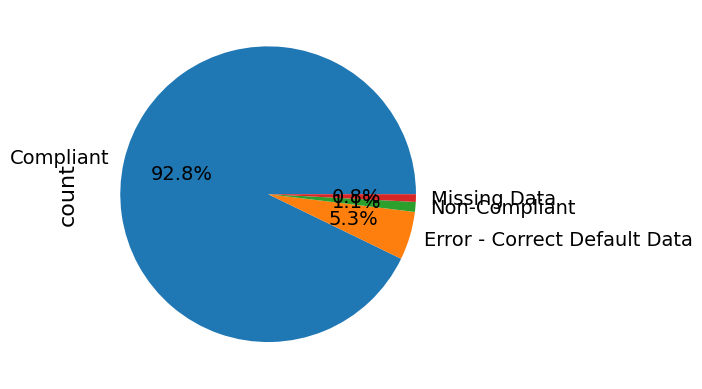

In [54]:
# Afficher les valeurs uniques de la colonne 'ComplianceStatus'
valeurs_uniques = df_cat['ComplianceStatus'].unique()

print(valeurs_uniques)

df_cat['ComplianceStatus'].value_counts().plot(kind="pie",  autopct='%1.1f%%')

Gardons uniquement les 'compliant'

In [55]:
print("Nombre de lignes avant la suppression :", df_cat.shape[0])
# Filtrage des données où aucune des colonnes clés n'a une valeur zéro
df_cat = df_cat[(df_cat['ComplianceStatus'] == 'Compliant')]
print("Nombre de lignes après la suppression :", df_cat.shape[0])

Nombre de lignes avant la suppression : 1668
Nombre de lignes après la suppression : 1548


La colonne 'ComplianceStatus' n'a désormais qu'une valeur. Supprimons la

In [56]:
df_cat = df_cat.drop(columns='ComplianceStatus')

In [57]:
df_cat.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address',
       'TaxParcelIdentificationNumber', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType'],
      dtype='object')

Regardons les property usetype

In [58]:
# Afficher les valeurs uniques de la colonne 'PrimaryPropertyType'
valeurs_uniques = df_cat['PrimaryPropertyType'].unique()

print(valeurs_uniques)

# Afficher les valeurs uniques de la colonne 'LargestPropertyUseType'
valeurs_uniques = df_cat['LargestPropertyUseType'].unique()

print(valeurs_uniques)

['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'K-12 School' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Supermarket / Grocery Store' 'Laboratory'
 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily']
['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Automobile Dealership'
 'Office' 'Self-Storage Facility' 'Non-Refrigerated Warehouse'
 'K-12 School' 'Other - Mall' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Distribution Center'
 'Parking' 'Multifamily Housing' 'Worship F

Il y a beaucoup de catégories dans 'LargestPropertyUseType'. On va supprimer cette colonne et garder uniquement 'PrimaryPropertyType' pour ne pas avoir un modèle trop complexe.

In [59]:
df_cat = df_cat.drop(columns='LargestPropertyUseType')

On va supprimer les usetypes liés à des usages résidentiels

In [60]:
# Définir les valeurs à exclure
valeurs_a_exclure = ["Residence Hall", "Senior Care Community", 
                     "Low-Rise Multifamily", "Mixed Use Property"]

# Filtrer le DataFrame
df_cat = df_cat[~df_cat['PrimaryPropertyType'].isin(valeurs_a_exclure)]

In [61]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1392 entries, 0 to 3373
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BuildingType                   1392 non-null   object
 1   PrimaryPropertyType            1392 non-null   object
 2   PropertyName                   1392 non-null   object
 3   Address                        1392 non-null   object
 4   TaxParcelIdentificationNumber  1392 non-null   object
 5   Neighborhood                   1392 non-null   object
 6   ListOfAllPropertyUseTypes      1392 non-null   object
dtypes: object(7)
memory usage: 87.0+ KB


Gardons uniquement les colonnes PrimaryPropertyType et Neighborhood

In [62]:
df_cat = df_cat.drop(columns=['BuildingType', 'PropertyName', 'Address', 
                              'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes'])

In [63]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1392 entries, 0 to 3373
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PrimaryPropertyType  1392 non-null   object
 1   Neighborhood         1392 non-null   object
dtypes: object(2)
memory usage: 32.6+ KB


Réduisons le combre de catégories dans PrimaryPropertyType. Pour cela on pourrait utiliser de nouvelles catégories comme 'Education', 'Healthcare', ...

Cependant ici nous allons les regrouper de façon plus intelligente en les classant par consommation d'énergie. Pour cela on doit utiliser lme dataframe complet. Cependant créons en une copie pour n'utiliser que les property types conservés dans df_cat

In [64]:
df_copy = df.copy()

In [65]:
values_to_exclude = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
df_copy = df_copy[~df_copy['BuildingType'].isin(values_to_exclude)]

In [66]:
df_copy = df_copy[(df_copy['ComplianceStatus'] == 'Compliant')]


In [67]:
variables_categorielles = df_copy.select_dtypes(include=['object', 'category'])
variables_categorielles.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address',
       'TaxParcelIdentificationNumber', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'ComplianceStatus'],
      dtype='object')

In [68]:
df_copy = df_copy.drop(columns=['BuildingType', 'PropertyName', 'Address',
       'TaxParcelIdentificationNumber', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'ComplianceStatus'])

In [69]:
# Définir les valeurs à exclure
valeurs_a_exclure = ["Residence Hall", "Senior Care Community", 
                     "Low-Rise Multifamily", "Mixed Use Property"]

# Filtrer le DataFrame
df_copy = df_copy[~df_copy['PrimaryPropertyType'].isin(valeurs_a_exclure)]

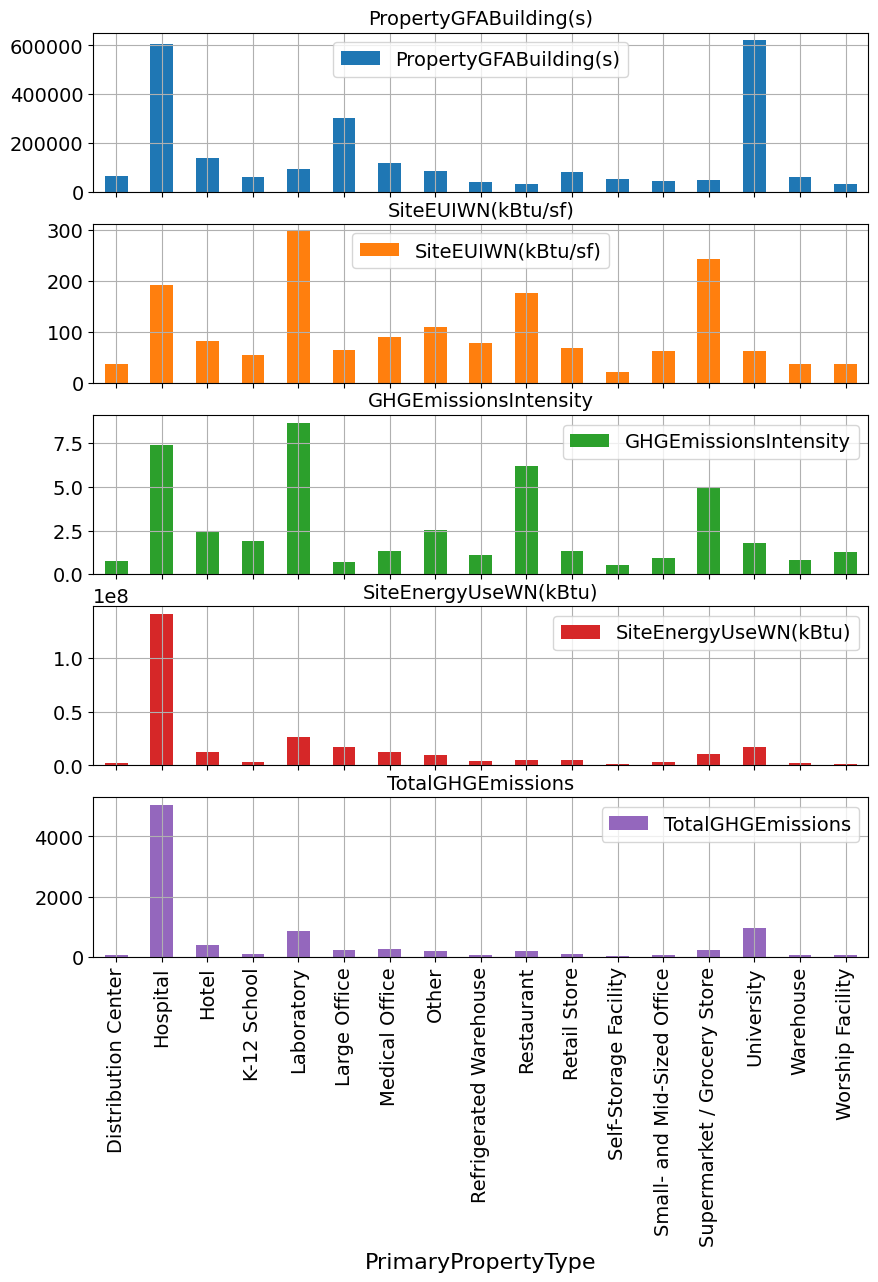

In [70]:
# Étape 1 : Regrouper les données
grouped = df_copy.groupby('PrimaryPropertyType')

# Étape 2 : Calculer les moyennes
mean_values = grouped[['PropertyGFABuilding(s)', 
                       'SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 
                       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']].mean()

# Étape 3 : Tracer les graphiques
mean_values.plot(kind='bar', subplots=True, figsize=(10, 12), grid=True)
plt.show()


#### 3.3.1 Regroupement des PrimaryPropertyType

In [71]:
def map_building_type_to_new_category(building_type):
    """
    Maps the building type to one of the eight new categories.
    
    Args:
    building_type (str): The type of the building.

    Returns:
    str: The new category of the building.
    """
    # Bâtiments Commerciaux et Administratifs
    if building_type in ['Large Office', 'Small- and Mid-Sized Office', 'Medical Office']:
        return 'Bâtiments Commerciaux et Administratifs'
    
    # Bâtiments Industriels et de Stockage
    elif building_type in ['Self-Storage Facility', 'Warehouse', 'Distribution Center', 'Refrigerated Warehouse']:
        return 'Bâtiments Industriels et de Stockage'

    # Bâtiments Éducatifs et Culturels
    elif building_type in ['K-12 School', 'University', 'Worship Facility']:
        return 'Bâtiments Éducatifs et Culturels'

    # Bâtiments de Vente et de Services
    elif building_type in ['Retail Store', 'Restaurant', 'Supermarket / Grocery Store']:
        return 'Bâtiments de Vente et de Services'

    # Bâtiments d'Hébergement
    elif building_type in ['Hotel']:
        return "Bâtiments d'Hébergement"

    # Bâtiments de Soins de Santé
    elif building_type in ['Hospital', 'Laboratory']:
        return 'Bâtiments de Soins de Santé'

    # Bâtiments Autres
    elif building_type == 'Other':
        return 'Bâtiments Autres'

    # Bâtiments Non Classifiés
    else:
        return 'Bâtiments Non Classifiés'


In [72]:
# Supposons que df est votre DataFrame et que 'Building_Type' est la colonne contenant les types de bâtiments
df_cat['GroupedPrimaryPropertyTypes'] = df_cat['PrimaryPropertyType'].apply(map_building_type_to_new_category)


In [73]:
# Afficher les valeurs uniques de la colonne 'GroupedPrimaryPropertyTypes'
unique_values = df_cat['PrimaryPropertyType'].unique()
print(unique_values)

['Hotel' 'Other' 'University' 'Small- and Mid-Sized Office'
 'Self-Storage Facility' 'Warehouse' 'K-12 School' 'Large Office'
 'Medical Office' 'Retail Store' 'Hospital' 'Distribution Center'
 'Worship Facility' 'Supermarket / Grocery Store' 'Laboratory'
 'Refrigerated Warehouse' 'Restaurant']


In [74]:
# Afficher les valeurs uniques de la colonne 'GroupedPrimaryPropertyTypes'
unique_values = df_cat['GroupedPrimaryPropertyTypes'].unique()
print(unique_values)

["Bâtiments d'Hébergement" 'Bâtiments Autres'
 'Bâtiments Éducatifs et Culturels'
 'Bâtiments Commerciaux et Administratifs'
 'Bâtiments Industriels et de Stockage'
 'Bâtiments de Vente et de Services' 'Bâtiments de Soins de Santé']


In [75]:
df_cat.head()

PrimaryPropertyType Neighborhood GroupedPrimaryPropertyTypes
0               Hotel     DOWNTOWN     Bâtiments d'Hébergement
1               Hotel     DOWNTOWN     Bâtiments d'Hébergement
2               Hotel     DOWNTOWN     Bâtiments d'Hébergement
3               Hotel     DOWNTOWN     Bâtiments d'Hébergement
4               Hotel     DOWNTOWN     Bâtiments d'Hébergement

In [76]:
df_cat = df_cat.drop(columns='PrimaryPropertyType')

In [77]:
df_cat.head()

Neighborhood GroupedPrimaryPropertyTypes
0     DOWNTOWN     Bâtiments d'Hébergement
1     DOWNTOWN     Bâtiments d'Hébergement
2     DOWNTOWN     Bâtiments d'Hébergement
3     DOWNTOWN     Bâtiments d'Hébergement
4     DOWNTOWN     Bâtiments d'Hébergement

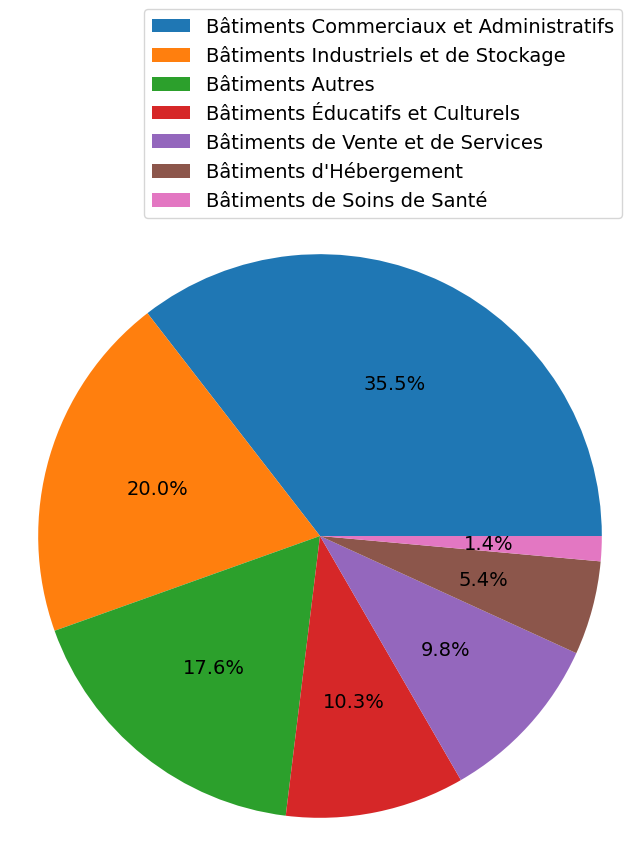

In [78]:
# Calculer les comptes des valeurs de la colonne 'PrimaryPropertyType'
value_counts = df_cat.GroupedPrimaryPropertyTypes.value_counts()

# Créer un pie plot avec pourcentages et ajustement de la taille de la figure
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(value_counts, autopct='%1.1f%%')

# Ajuster le cercle pour qu'il soit bien proportionné
plt.axis('equal')

# Définir la position de la légende en dehors du plot
plt.legend(patches, value_counts.index, loc="best", bbox_to_anchor=(0.2, 1)
           )

# Afficher le pie plot
plt.show()


### 3.4 Nettoyage de df_num

In [79]:
# Sélectionner les lignes dans df_num qui ont des indices présents dans df_cat_encoded
df_num = df_num.loc[df_cat.index]

# Maintenant, df_num contient seulement les lignes avec les indices correspondants à ceux de df_cat_encoded

In [80]:
df.loc[1234]

OSEBuildingID                                          21322
BuildingType                                  NonResidential
PrimaryPropertyType              Small- and Mid-Sized Office
PropertyName                                Fourth and Union
Address                                      1404 Fourth Ave
ZipCode                                              98101.0
TaxParcelIdentificationNumber                     1975700290
CouncilDistrictCode                                        7
Neighborhood                                        DOWNTOWN
Latitude                                            47.60952
Longitude                                         -122.33558
YearBuilt                                               1928
NumberofBuildings                                        1.0
NumberofFloors                                             4
PropertyGFATotal                                       30525
PropertyGFAParking                                         0
PropertyGFABuilding(s)  

In [81]:
df_num.loc[1234]

OSEBuildingID                2.132200e+04
ZipCode                      9.810100e+04
CouncilDistrictCode          7.000000e+00
Latitude                     4.760952e+01
Longitude                   -1.223356e+02
YearBuilt                    1.928000e+03
NumberofBuildings            1.000000e+00
NumberofFloors               4.000000e+00
PropertyGFATotal             3.052500e+04
PropertyGFAParking           0.000000e+00
PropertyGFABuilding(s)       3.052500e+04
LargestPropertyUseTypeGFA    1.560900e+04
ENERGYSTARScore              1.700000e+01
SiteEUI(kBtu/sf)             1.328000e+02
SiteEUIWN(kBtu/sf)           1.378000e+02
SourceEUI(kBtu/sf)           3.490000e+02
SourceEUIWN(kBtu/sf)         3.550000e+02
SiteEnergyUse(kBtu)          2.883139e+06
SiteEnergyUseWN(kBtu)        2.991557e+06
SteamUse(kBtu)               7.620328e+05
Electricity(kWh)             6.216606e+05
Electricity(kBtu)            2.121106e+06
NaturalGas(therms)           0.000000e+00
NaturalGas(kBtu)             0.000

In [82]:
df_cat.tail()

Neighborhood GroupedPrimaryPropertyTypes
3365                BALLARD            Bâtiments Autres
3367                   EAST            Bâtiments Autres
3370               DELRIDGE            Bâtiments Autres
3372               DOWNTOWN            Bâtiments Autres
3373  MAGNOLIA / QUEEN ANNE            Bâtiments Autres

In [83]:
df_num.tail()

OSEBuildingID  ZipCode  CouncilDistrictCode  Latitude  Longitude  \
3365          50208      NaN                    6  47.67734 -122.37624   
3367          50212      NaN                    3  47.63228 -122.31574   
3370          50221      NaN                    1  47.54067 -122.37441   
3372          50223      NaN                    2  47.59625 -122.32283   
3373          50224      NaN                    7  47.63644 -122.35784   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
3365       1972                1.0               1             12769   
3367       1912                1.0               1             23445   
3370       1982                1.0               1             18261   
3372       2004                1.0               1             16000   
3373       1974                1.0               1             13157   

      PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
3365                   0                   12769                    10912.0   
3367                   0                   23445                    23445.0   
3370                   0                   18261                    18261.0   
3372                   0                   16000                    16000.0   
3373                   0                   13157                     7583.0   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3365              NaN        400.799988          420.600006   
3367              NaN        254.899994          286.500000   
3370              NaN         51.000000           56.200001   
3372              NaN         59.400002           65.900002   
3373              NaN        438.200012          460.100006   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3365          618.099976            638.900024         5.117308e+06   
3367          380.100006            413.200012         5.976246e+06   
3370          126.000000            136.600006         9.320821e+05   
3372          114.199997            118.900002         9.502762e+05   
3373          744.799988            767.799988         5.765898e+06   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3365            5370263.500             0.0       353216.0938   
3367            6716330.000             0.0       369539.8125   
3370            1025432.125             0.0       185334.7031   
3372            1053705.750             0.0       116221.0000   
3373            6053764.500             0.0       525251.6875   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
3365       1.205173e+06        39121.351560      3.912135e+06   
3367       1.260870e+06        47153.757810      4.715376e+06   
3370       6.323620e+05         2997.199951      2.997200e+05   
3372       3.965461e+05         5537.299805      5.537300e+05   
3373       1.792159e+06        39737.390630      3.973739e+06   

      TotalGHGEmissions  GHGEmissionsIntensity  
3365             216.18                  16.93  
3367             259.22                  11.06  
3370              20.33                   1.11  
3372              32.17                   2.01  
3373             223.54                  16.99

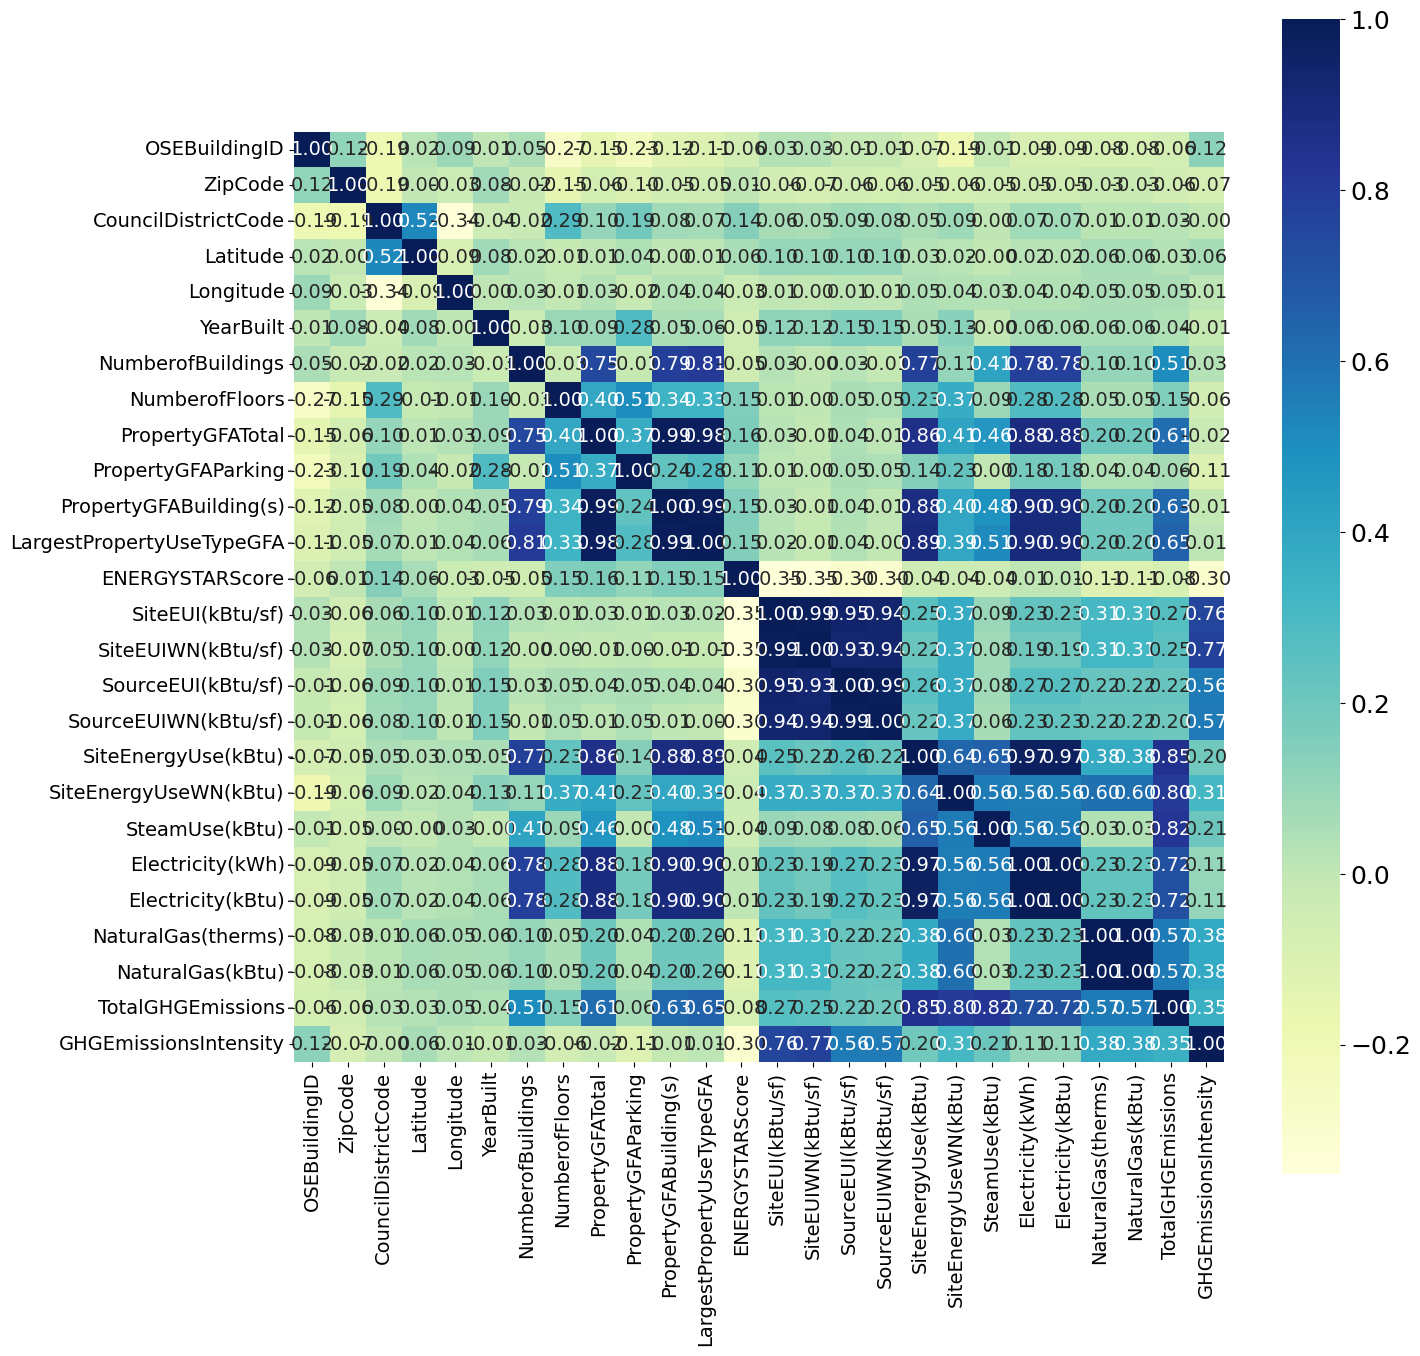

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_title('Matrice de corrélation', fontdict={'fontsize':18}, x=0.5, y=1.1)

# Create the heatmap
corr_heatmap = sns.heatmap(df_num.corr(), 
                           annot=True, square=True, ax=ax, fmt='.2f', cmap='YlGnBu')

# Modify colorbar label fontsize
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18) # Adjust as needed

plt.show()

#### 3.4.1 Création d'une colonne 'dist_to_downtown'

Localisation des bâtiments

In [85]:
map_osm = folium.Map()
map_osm = folium.Map(location=[df_num['Latitude'].mean(), df_num['Longitude'].mean()],zoom_start=11)
for i in range(0,len(df_num)):
    folium.Circle([df_num.iloc[i]['Latitude'],df_num.iloc[i]['Longitude']], 
                      popup=df.iloc[i]['Address'], radius =100).add_to(map_osm)
map_osm

In [86]:
 # Coordonnées du centre-ville de Seattle
downtown_coords = (47.60501282866967, -122.33359882230069)

# Fonction pour calculer la distance au centre-ville
def calculate_distance(lat, lon):
    return geodesic((lat, lon), downtown_coords).kilometers

# Application de la fonction pour calculer la distance pour chaque bâtiment
df_num['DistanceToDowntown'] = df_num.apply(lambda x: calculate_distance(x['Latitude'], x['Longitude']), axis=1)

# Affichage des premières lignes pour vérifier la nouvelle colonne
df_num[['Latitude', 'Longitude', 'DistanceToDowntown']].head()


Latitude  Longitude  DistanceToDowntown
0  47.61220 -122.33799            0.864611
1  47.61317 -122.33393            0.907278
2  47.61393 -122.33810            1.047606
3  47.61412 -122.33664            1.038057
4  47.61375 -122.34047            1.100255

#### 3.4.2 Suppression de colonnes inutiles 

In [87]:
df_num.columns

Index(['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DistanceToDowntown'],
      dtype='object')

In [88]:
colonnes_inutiles = ['OSEBuildingID','Latitude', 
                     'Longitude']

df_num = df_num.drop(columns=colonnes_inutiles)

In [89]:
df_num.columns

Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DistanceToDowntown'],
      dtype='object')

#### 3.4.3 Comparaison Surface totale et Sufrace Parkings+Surface Bâtiments

In [90]:
# Comparez PropertyGFATotal avec la somme de PropertyGFAParking et PropertyGFABuilding(s)
df_num['Comparison_Result'] = df_num['PropertyGFATotal'] == df_num['PropertyGFAParking'] + df_num['PropertyGFABuilding(s)']

print(df_num['Comparison_Result'])

# Comptez le nombre de True et de False dans la colonne Comparison_Result
result_counts = df_num['Comparison_Result'].value_counts()

print(result_counts)

0       True
1       True
2       True
3       True
4       True
        ... 
3365    True
3367    True
3370    True
3372    True
3373    True
Name: Comparison_Result, Length: 1392, dtype: bool
Comparison_Result
True    1392
Name: count, dtype: int64


In [91]:
df_num = df_num.drop(columns='Comparison_Result')

Supprimons les surfaces building et parking 

In [92]:
# df_num = df_num.drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)'])

In [93]:
df_num.columns

Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DistanceToDowntown'],
      dtype='object')

#### 4.3.4 Gardons les unités kBtu

In [94]:
df_num = df_num.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)'])

#### 4.3.5 Valeurs négatives

In [95]:
df_num.min()

ZipCode                       98006.000000
CouncilDistrictCode               1.000000
YearBuilt                      1900.000000
NumberofBuildings                 0.000000
NumberofFloors                    0.000000
PropertyGFATotal              11285.000000
PropertyGFAParking                0.000000
PropertyGFABuilding(s)        11285.000000
LargestPropertyUseTypeGFA      7583.000000
ENERGYSTARScore                   1.000000
SiteEUI(kBtu/sf)                  1.400000
SiteEUIWN(kBtu/sf)                0.000000
SourceEUI(kBtu/sf)                0.000000
SourceEUIWN(kBtu/sf)             -2.100000
SiteEnergyUse(kBtu)           57133.199220
SiteEnergyUseWN(kBtu)             0.000000
SteamUse(kBtu)                    0.000000
Electricity(kBtu)           -115417.000000
NaturalGas(kBtu)                  0.000000
TotalGHGEmissions                -0.800000
GHGEmissionsIntensity            -0.020000
DistanceToDowntown                0.050637
dtype: float64

C'est la même ligne à chaque fois. Supprimons la

In [96]:
df_num[df_num['GHGEmissionsIntensity']<0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
3206  98122.0                    3       2013                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3206               6             52000                   0   

      PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
3206                   52000                    48159.0            100.0   

      SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
3206               7.1                 5.0                 2.0   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
3206                  -2.1          342726.0938            240132.0938   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
3206             0.0          -115417.0               0.0               -0.8   

      GHGEmissionsIntensity  DistanceToDowntown  
3206                  -0.02            1.889611

In [97]:
df_num[df_num['SourceEUIWN(kBtu/sf)']<0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
3206  98122.0                    3       2013                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3206               6             52000                   0   

      PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
3206                   52000                    48159.0            100.0   

      SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
3206               7.1                 5.0                 2.0   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
3206                  -2.1          342726.0938            240132.0938   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
3206             0.0          -115417.0               0.0               -0.8   

      GHGEmissionsIntensity  DistanceToDowntown  
3206                  -0.02            1.889611

In [98]:
df_num[df_num['Electricity(kBtu)']<0]


ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
3206  98122.0                    3       2013                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3206               6             52000                   0   

      PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
3206                   52000                    48159.0            100.0   

      SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
3206               7.1                 5.0                 2.0   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
3206                  -2.1          342726.0938            240132.0938   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
3206             0.0          -115417.0               0.0               -0.8   

      GHGEmissionsIntensity  DistanceToDowntown  
3206                  -0.02            1.889611

In [99]:
df_num.drop(3206, inplace=True)

In [100]:
df_num.min()

ZipCode                      98006.000000
CouncilDistrictCode              1.000000
YearBuilt                     1900.000000
NumberofBuildings                0.000000
NumberofFloors                   0.000000
PropertyGFATotal             11285.000000
PropertyGFAParking               0.000000
PropertyGFABuilding(s)       11285.000000
LargestPropertyUseTypeGFA     7583.000000
ENERGYSTARScore                  1.000000
SiteEUI(kBtu/sf)                 1.400000
SiteEUIWN(kBtu/sf)               0.000000
SourceEUI(kBtu/sf)               0.000000
SourceEUIWN(kBtu/sf)             0.000000
SiteEnergyUse(kBtu)          57133.199220
SiteEnergyUseWN(kBtu)            0.000000
SteamUse(kBtu)                   0.000000
Electricity(kBtu)                0.000000
NaturalGas(kBtu)                 0.000000
TotalGHGEmissions                0.000000
GHGEmissionsIntensity            0.000000
DistanceToDowntown               0.050637
dtype: float64

#### 4.3.6 Valeurs nulles

##### 4.3.6.1 Correction du nombre de bâtiments et d'étages (ne peut être 0)

In [101]:
df_num['NumberofBuildings'].replace(0, 1, inplace=True)
df_num['NumberofFloors'].replace(0, 1, inplace=True)

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_58595/1667441221.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_num['NumberofBuildings'].replace(0, 1, inplace=True)
/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_58595/1667441221.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [102]:
df_num.min()

ZipCode                      98006.000000
CouncilDistrictCode              1.000000
YearBuilt                     1900.000000
NumberofBuildings                1.000000
NumberofFloors                   1.000000
PropertyGFATotal             11285.000000
PropertyGFAParking               0.000000
PropertyGFABuilding(s)       11285.000000
LargestPropertyUseTypeGFA     7583.000000
ENERGYSTARScore                  1.000000
SiteEUI(kBtu/sf)                 1.400000
SiteEUIWN(kBtu/sf)               0.000000
SourceEUI(kBtu/sf)               0.000000
SourceEUIWN(kBtu/sf)             0.000000
SiteEnergyUse(kBtu)          57133.199220
SiteEnergyUseWN(kBtu)            0.000000
SteamUse(kBtu)                   0.000000
Electricity(kBtu)                0.000000
NaturalGas(kBtu)                 0.000000
TotalGHGEmissions                0.000000
GHGEmissionsIntensity            0.000000
DistanceToDowntown               0.050637
dtype: float64

In [103]:
df_num[df_num['SiteEnergyUseWN(kBtu)']==0].shape

(9, 22)

In [104]:
df_num[df_num['SiteEnergyUseWN(kBtu)']==0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
220   98104.0                    7       1958                1.0   
247   98101.0                    7       1988                1.0   
284   98101.0                    7       1929                1.0   
350   98119.0                    7       1971                1.0   
882   98115.0                    6       1910                1.0   
953   98115.0                    4       2000                1.0   
3274  98105.0                    4       1900              111.0   
3275  98195.0                    4       1969                1.0   
3277  98195.0                    4       1998                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
220               17            378525               84600   
247               20            497513              118744   
284               15            151039                   0   
350                5             88000               21600   
882                2             23931                   0   
953                2             31386                   0   
3274               1           9320156                   0   
3275               4             58779                   0   
3277               6            203030                   0   

      PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
220                   293925                   236827.0             69.0   
247                   378769                   367623.0             65.0   
284                   151039                   125473.0             84.0   
350                    66400                    69691.0             75.0   
882                    23931                    23931.0             88.0   
953                    31386                    30000.0             52.0   
3274                 9320156                  9320156.0              NaN   
3275                   58779                    58779.0              NaN   
3277                  203030                   203030.0              NaN   

      SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
220         105.199997                 0.0          240.899994   
247          73.000000                 0.0          227.899994   
284          43.400002                 0.0           92.300003   
350          50.000000                 0.0          157.000000   
882          20.700001                 0.0           36.400002   
953          37.599998                 0.0           89.000000   
3274         93.800003                 0.0          246.600006   
3275         85.099998                 0.0          221.000000   
3277        252.000000                 0.0          561.000000   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
220                    0.0         2.490613e+07                    0.0   
247                    0.0         2.682322e+07                    0.0   
284                    0.0         5.446624e+06                    0.0   
350                    0.0         3.484916e+06                    0.0   
882                    0.0         4.964773e+05                    0.0   
953                    0.0         1.128179e+06                    0.0   
3274                   0.0         8.739237e+08                    0.0   
3275                   0.0         5.000717e+06                    0.0   
3277                   0.0         5.116831e+07                    0.0   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
220      10921066.00         13985064.0               0.0             940.47   
247             0.00         26602310.0          220905.0             197.19   
284       2850077.75          2596546.0               0.0             238.09   
350             0.00          3484915.0               0.0              24.29   
882             0.00           167075.0          329402.0              18.66   
953             0.00           710478.0          417701.0    

In [105]:
df_num[df_num['GHGEmissionsIntensity']==0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
513  98119.0                    7       2008                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
513               1             57176                   0   

     PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
513                   57176                    39500.0             31.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
513        208.800003          214.100006                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
513                   0.0           12525174.0             12843856.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
513             0.0                0.0               0.0                0.0   

     GHGEmissionsIntensity  DistanceToDowntown  
513                    0.0            4.858197

In [106]:
df_num[df_num['Electricity(kBtu)']==0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
426  98101.0                    7       1900                1.0   
513  98119.0                    7       2008                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
426               1             43728                   0   
513               1             57176                   0   

     PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
426                   43728                    43728.0              NaN   
513                   57176                    39500.0             31.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
426        263.200012          271.100006          276.299988   
513        208.800003          214.100006            0.000000   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
426            284.600006           11508035.0             11854450.0   
513              0.000000           12525174.0             12843856.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
426             0.0                0.0        11508035.0             611.19   
513             0.0                0.0               0.0               0.00   

     GHGEmissionsIntensity  DistanceToDowntown  
426                  13.98            0.581219  
513                   0.00            4.858197

In [107]:
# Supposons que df_num est votre DataFrame
# Supprimer les lignes où 'SiteEnergyUseWN(kBtu)' est égal à 0
df_num = df_num[df_num['SiteEnergyUseWN(kBtu)'] != 0]

In [108]:
df_num.min()

ZipCode                      98006.000000
CouncilDistrictCode              1.000000
YearBuilt                     1900.000000
NumberofBuildings                1.000000
NumberofFloors                   1.000000
PropertyGFATotal             11285.000000
PropertyGFAParking               0.000000
PropertyGFABuilding(s)       11285.000000
LargestPropertyUseTypeGFA     7583.000000
ENERGYSTARScore                  1.000000
SiteEUI(kBtu/sf)                 1.400000
SiteEUIWN(kBtu/sf)               1.500000
SourceEUI(kBtu/sf)               0.000000
SourceEUIWN(kBtu/sf)             0.000000
SiteEnergyUse(kBtu)          57133.199220
SiteEnergyUseWN(kBtu)        58114.199220
SteamUse(kBtu)                   0.000000
Electricity(kBtu)                0.000000
NaturalGas(kBtu)                 0.000000
TotalGHGEmissions                0.000000
GHGEmissionsIntensity            0.000000
DistanceToDowntown               0.050637
dtype: float64

In [109]:
df_num[df_num['SourceEUIWN(kBtu/sf)']==0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
513  98119.0                    7       2008                1.0   
563  98121.0                    7       1979                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
513               1             57176                   0   
563               7            131143               87160   

     PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
513                   57176                    39500.0             31.0   
563                   43983                   120248.0             93.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
513        208.800003          214.100006                 0.0   
563         39.500000                 NaN               128.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
513                   0.0           12525174.0             12843856.0   
563                   0.0            5177270.5                    NaN   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
513             0.0                0.0               0.0               0.00   
563             0.0          4871126.0         1416041.0             109.16   

     GHGEmissionsIntensity  DistanceToDowntown  
513                   0.00            4.858197  
563                   0.83            1.015821

In [110]:
df_num = df_num[df_num['SourceEUIWN(kBtu/sf)'] != 0]

In [111]:
df_num.min()

ZipCode                      98006.000000
CouncilDistrictCode              1.000000
YearBuilt                     1900.000000
NumberofBuildings                1.000000
NumberofFloors                   1.000000
PropertyGFATotal             11285.000000
PropertyGFAParking               0.000000
PropertyGFABuilding(s)       11285.000000
LargestPropertyUseTypeGFA     7583.000000
ENERGYSTARScore                  1.000000
SiteEUI(kBtu/sf)                 1.400000
SiteEUIWN(kBtu/sf)               1.500000
SourceEUI(kBtu/sf)               4.500000
SourceEUIWN(kBtu/sf)             4.600000
SiteEnergyUse(kBtu)          57133.199220
SiteEnergyUseWN(kBtu)        58114.199220
SteamUse(kBtu)                   0.000000
Electricity(kBtu)                0.000000
NaturalGas(kBtu)                 0.000000
TotalGHGEmissions                0.400000
GHGEmissionsIntensity            0.010000
DistanceToDowntown               0.050637
dtype: float64

In [112]:
df_num[df_num['Electricity(kBtu)']==0]

ZipCode  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
426  98101.0                    7       1900                1.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
426               1             43728                   0   

     PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
426                   43728                    43728.0              NaN   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
426        263.200012          271.100006          276.299988   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
426            284.600006           11508035.0             11854450.0   

     SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
426             0.0                0.0        11508035.0             611.19   

     GHGEmissionsIntensity  DistanceToDowntown  
426                  13.98            0.581219

In [113]:
df_num = df_num[df_num['Electricity(kBtu)'] != 0]

In [114]:
df_num.min()

ZipCode                      98006.000000
CouncilDistrictCode              1.000000
YearBuilt                     1900.000000
NumberofBuildings                1.000000
NumberofFloors                   1.000000
PropertyGFATotal             11285.000000
PropertyGFAParking               0.000000
PropertyGFABuilding(s)       11285.000000
LargestPropertyUseTypeGFA     7583.000000
ENERGYSTARScore                  1.000000
SiteEUI(kBtu/sf)                 1.400000
SiteEUIWN(kBtu/sf)               1.500000
SourceEUI(kBtu/sf)               4.500000
SourceEUIWN(kBtu/sf)             4.600000
SiteEnergyUse(kBtu)          57133.199220
SiteEnergyUseWN(kBtu)        58114.199220
SteamUse(kBtu)                   0.000000
Electricity(kBtu)                3.000000
NaturalGas(kBtu)                 0.000000
TotalGHGEmissions                0.400000
GHGEmissionsIntensity            0.010000
DistanceToDowntown               0.050637
dtype: float64

#### 4.3.7 Corrélations

In [115]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

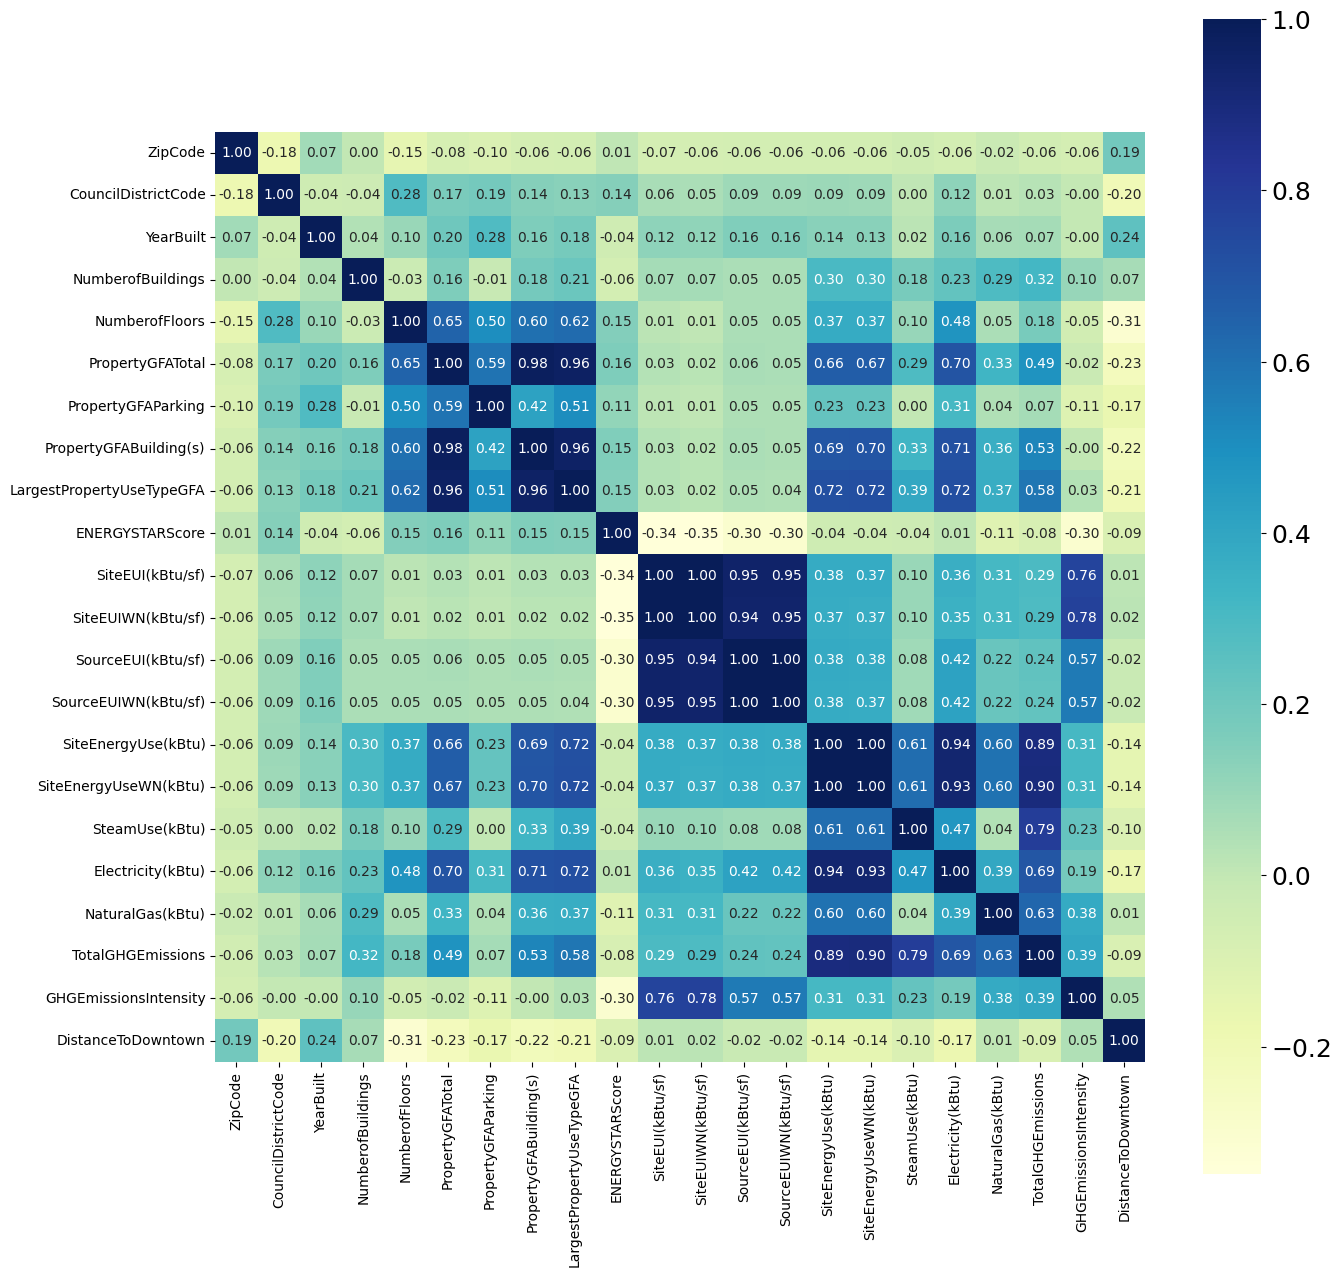

In [116]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_title('Matrice de corrélation', fontdict={'fontsize':18}, x=0.5, y=1.1)

# Create the heatmap
corr_heatmap = sns.heatmap(df_num.corr(), 
                           annot=True, square=True, ax=ax, fmt='.2f', cmap='YlGnBu')

# Modify colorbar label fontsize
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18) # Adjust as needed

plt.show()

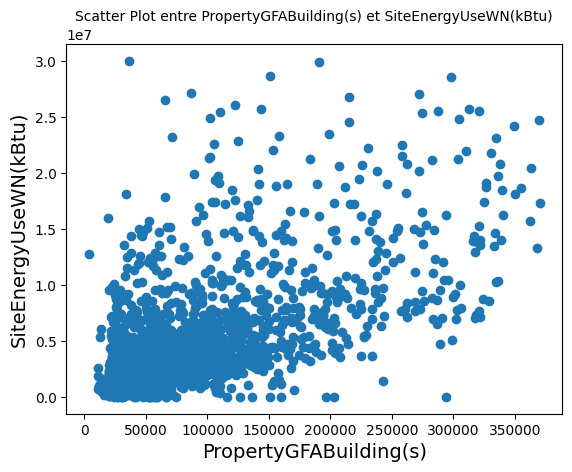

In [117]:
# Identifiez les variables corrélées que vous souhaitez tracer
variable2 = 'SiteEnergyUseWN(kBtu)'
variable1 = 'PropertyGFABuilding(s)'

# Définissez un seuil pour exclure les valeurs extrêmes (par exemple, 95e percentile)
threshold = 0.95

# Calculer les quantiles pour les deux variables
quantile_var1 = df_num[variable1].quantile(threshold)
quantile_var2 = df_num[variable2].quantile(threshold)

# Filtrer les données pour exclure les valeurs extrêmes
filtered_data = df[(df[variable1] < quantile_var1) & (df[variable2] < quantile_var2)]

# Créer un scatter plot entre les deux variables corrélées
plt.scatter(filtered_data[variable1], filtered_data[variable2])

# Ajouter des labels et un titre
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.title(f'Scatter Plot entre {variable1} et {variable2}')

# Afficher le scatter plot
plt.show()

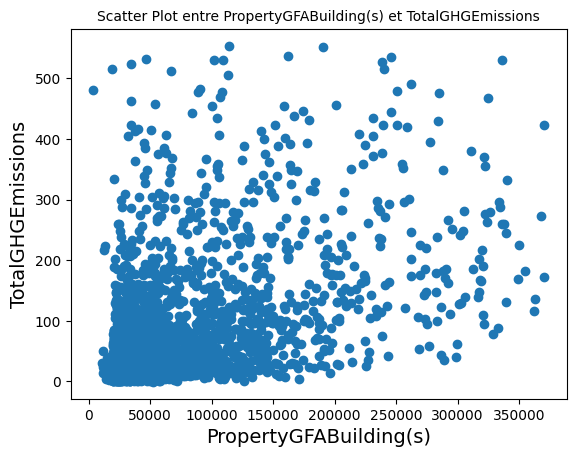

In [118]:
# Identifiez les variables corrélées que vous souhaitez tracer
variable2 = 'TotalGHGEmissions'
variable1 = 'PropertyGFABuilding(s)'

# Définissez un seuil pour exclure les valeurs extrêmes (par exemple, 95e percentile)
threshold = 0.95

# Calculer les quantiles pour les deux variables
quantile_var1 = df_num[variable1].quantile(threshold)
quantile_var2 = df_num[variable2].quantile(threshold)

# Filtrer les données pour exclure les valeurs extrêmes
filtered_data = df[(df[variable1] < quantile_var1) & (df[variable2] < quantile_var2)]

# Créer un scatter plot entre les deux variables corrélées
plt.scatter(filtered_data[variable1], filtered_data[variable2])

# Ajouter des labels et un titre
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.title(f'Scatter Plot entre {variable1} et {variable2}')

# Afficher le scatter plot
plt.show()

Nos targets sont : **SiteEnergyUseWN(kBtu)** et **TotalGHGEmissions**. 


#### 4.3.8 Donées structurelles

On souhaite déterminer les targets en connaissant uniquement les données structurelles des bâtiments (i.e. sans faire de relevés sur les consommations/émissions).

In [119]:
df_num.columns

Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DistanceToDowntown'],
      dtype='object')

In [120]:
df_num = df_num.drop(columns=['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'GHGEmissionsIntensity'])

#### 4.3.9 Variables correles avec les targets

On va garder les variables qui ont des corrélations entre 5 et 70% avec les targets

In [121]:
# Calculer la matrice de corrélation
corr_matrix = df_num.corr()

# Identifier les variables qui ont une corrélation entre 5% et 70% avec les cibles
target_1 = "SiteEnergyUseWN(kBtu)"
target_2 = "TotalGHGEmissions"

corr_with_target_1 = corr_matrix[target_1].abs()
corr_with_target_2 = corr_matrix[target_2].abs()

In [122]:
corr_with_target_1*100

ZipCode                        6.200086
CouncilDistrictCode            8.750878
YearBuilt                     13.469609
NumberofBuildings             30.310071
NumberofFloors                37.443235
PropertyGFATotal              66.793337
PropertyGFAParking            22.665681
PropertyGFABuilding(s)        69.581375
LargestPropertyUseTypeGFA     72.276558
ENERGYSTARScore                3.842233
SiteEnergyUseWN(kBtu)        100.000000
TotalGHGEmissions             89.554532
DistanceToDowntown            14.138910
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [123]:
corr_with_target_2*100

ZipCode                        5.560532
CouncilDistrictCode            2.913554
YearBuilt                      7.144603
NumberofBuildings             31.672488
NumberofFloors                17.547120
PropertyGFATotal              48.839999
PropertyGFAParking             7.244414
PropertyGFABuilding(s)        53.187028
LargestPropertyUseTypeGFA     58.238896
ENERGYSTARScore                8.053701
SiteEnergyUseWN(kBtu)         89.554532
TotalGHGEmissions            100.000000
DistanceToDowntown             8.856199
Name: TotalGHGEmissions, dtype: float64

Par nos étapes précédentes on a déjà gardé uniquement les variables corrélées entre 5 et 70% aux targets

#### 4.3.10 Variable inter-corrélées

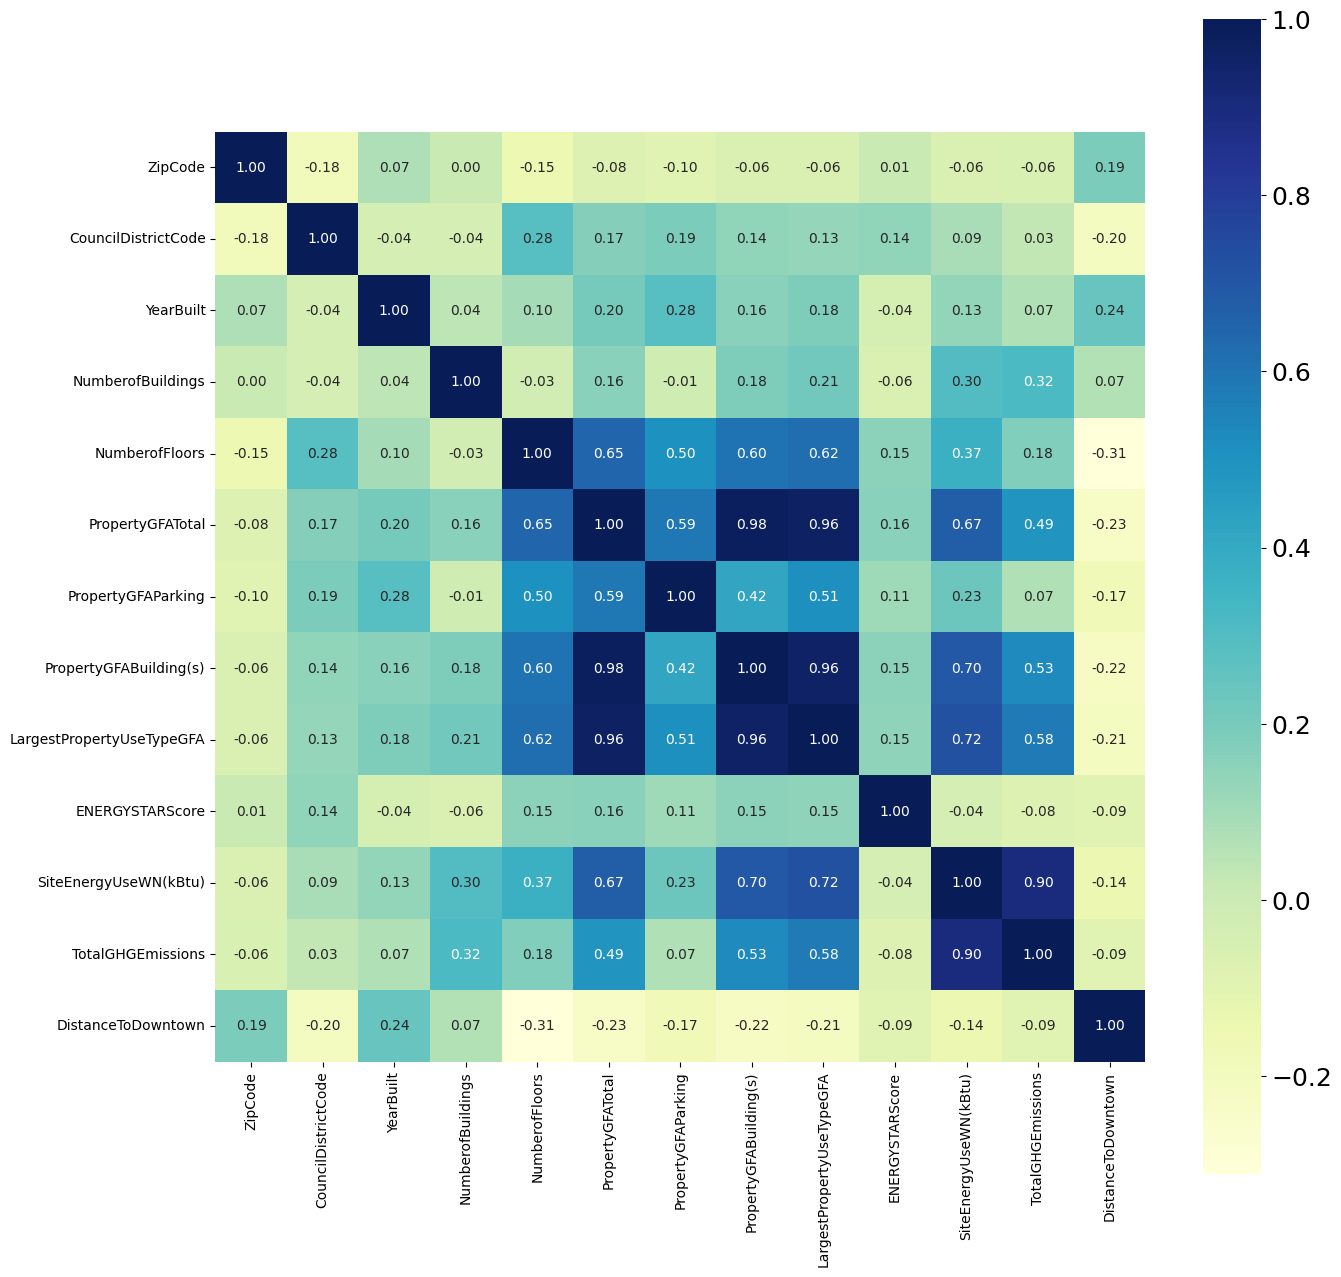

In [124]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_title('Matrice de corrélation', fontdict={'fontsize':18}, x=0.5, y=1.1)

# Create the heatmap
corr_heatmap = sns.heatmap(df_num.corr(), 
                           annot=True, square=True, ax=ax, fmt='.2f', cmap='YlGnBu')

# Modify colorbar label fontsize
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18) # Adjust as needed

plt.show()

Les variables de surface sont redondantes. Supprimons les et ne gardons que la surface totale de batiments

In [125]:
df_num.columns

Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
       'DistanceToDowntown'],
      dtype='object')

In [126]:
df_num = df_num.drop(columns=['PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseTypeGFA'])

In [127]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ZipCode                 1370 non-null   float64
 1   CouncilDistrictCode     1379 non-null   int64  
 2   YearBuilt               1379 non-null   int64  
 3   NumberofBuildings       1379 non-null   float64
 4   NumberofFloors          1379 non-null   int64  
 5   PropertyGFABuilding(s)  1379 non-null   int64  
 6   ENERGYSTARScore         924 non-null    float64
 7   SiteEnergyUseWN(kBtu)   1379 non-null   float64
 8   TotalGHGEmissions       1379 non-null   float64
 9   DistanceToDowntown      1379 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 118.5 KB


### 4.5 Importances des features avec k-best

In [128]:
# Splitting the dataframe into two based on the targets
df_for_SiteEnergyUse = df_num.drop('TotalGHGEmissions', axis=1)
df_for_TotalGHGEmissions = df_num.drop('SiteEnergyUseWN(kBtu)', axis=1)

# For 'SiteEnergyUseWN(kBtu)'
X_SiteEnergyUse = df_for_SiteEnergyUse.drop('SiteEnergyUseWN(kBtu)', axis=1)
y_SiteEnergyUse = df_for_SiteEnergyUse['SiteEnergyUseWN(kBtu)']

# Drop NaN values
X_SiteEnergyUse = X_SiteEnergyUse.dropna()
y_SiteEnergyUse = y_SiteEnergyUse[X_SiteEnergyUse.index]

# For 'TotalGHGEmissions'
X_TotalGHGEmissions = df_for_TotalGHGEmissions.drop('TotalGHGEmissions', axis=1)
y_TotalGHGEmissions = df_for_TotalGHGEmissions['TotalGHGEmissions']

# Drop NaN values
X_TotalGHGEmissions = X_TotalGHGEmissions.dropna()
y_TotalGHGEmissions = y_TotalGHGEmissions[X_TotalGHGEmissions.index]

# For 'SiteEnergyUseWN(kBtu)'
X_SiteEnergyUse = X_SiteEnergyUse.loc[:, X_SiteEnergyUse.nunique() > 1]

# For 'TotalGHGEmissions'
X_TotalGHGEmissions = X_TotalGHGEmissions.loc[:, X_TotalGHGEmissions.nunique() > 1]

X_SiteEnergyUse = X_SiteEnergyUse.select_dtypes(include=[np.number])
X_TotalGHGEmissions = X_TotalGHGEmissions.select_dtypes(include=[np.number])


# For 'SiteEnergyUseWN(kBtu)'
selector_SiteEnergyUse = SelectKBest(score_func=f_regression, k='all')
X_new_SiteEnergyUse = selector_SiteEnergyUse.fit_transform(X_SiteEnergyUse, y_SiteEnergyUse)

# For 'TotalGHGEmissions'
selector_TotalGHGEmissions = SelectKBest(score_func=f_regression, k='all')
X_new_TotalGHGEmissions = selector_TotalGHGEmissions.fit_transform(X_TotalGHGEmissions, y_TotalGHGEmissions)

mask_SiteEnergyUse = selector_SiteEnergyUse.get_support()
selected_features_SiteEnergyUse = X_SiteEnergyUse.columns[mask_SiteEnergyUse]
print("Selected features for SiteEnergyUseWN(kBtu):")
print(selected_features_SiteEnergyUse)

mask_TotalGHGEmissions = selector_TotalGHGEmissions.get_support()
selected_features_TotalGHGEmissions = X_TotalGHGEmissions.columns[mask_TotalGHGEmissions]
print("Selected features for TotalGHGEmissions:")
print(selected_features_TotalGHGEmissions)


Selected features for SiteEnergyUseWN(kBtu):
Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'DistanceToDowntown'],
      dtype='object')
Selected features for TotalGHGEmissions:
Index(['ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'DistanceToDowntown'],
      dtype='object')


In [129]:
# Get scores assigned by SelectKBest
scores_SiteEnergyUse = selector_SiteEnergyUse.scores_

# Pair feature names with their scores
features_scores_SiteEnergyUse = list(zip(X_SiteEnergyUse.columns, scores_SiteEnergyUse))

# Sort the features by their scores
sorted_features_SiteEnergyUse = sorted(features_scores_SiteEnergyUse, key=lambda x: x[1], reverse=True)

# Print ranked features
print("Ranked features for SiteEnergyUseWN(kBtu):")
for feature, score in sorted_features_SiteEnergyUse:
    print(f"{feature}: {score}")
    
print()
# Get scores assigned by SelectKBest
scores_TotalGHGEmissions = selector_TotalGHGEmissions.scores_

# Pair feature names with their scores
features_scores_TotalGHGEmissions = list(zip(X_TotalGHGEmissions.columns, scores_TotalGHGEmissions))

# Sort the features by their scores
sorted_features_TotalGHGEmissions = sorted(features_scores_TotalGHGEmissions, key=lambda x: x[1], reverse=True)

# Print ranked features
print("Ranked features for TotalGHGEmissions:")
for feature, score in sorted_features_TotalGHGEmissions:
    print(f"{feature}: {score}")



Ranked features for SiteEnergyUseWN(kBtu):
PropertyGFABuilding(s): 838.8788731246456
NumberofBuildings: 619.5410001825608
NumberofFloors: 165.84859587049408
DistanceToDowntown: 20.87376775139282
YearBuilt: 13.462101032289636
CouncilDistrictCode: 9.177923612693334
ZipCode: 2.2316657698354425
ENERGYSTARScore: 1.3631384845492351

Ranked features for TotalGHGEmissions:
NumberofBuildings: 1196.3077888301807
PropertyGFABuilding(s): 352.18240380171864
NumberofFloors: 28.811978926432328
DistanceToDowntown: 6.276358824540153
ENERGYSTARScore: 6.019328750973609
YearBuilt: 2.6353054284705255
ZipCode: 1.9756797179643513
CouncilDistrictCode: 0.6418552823073277


On voit que 'CouncilDistrictCode' et 'ZipCode' ont un score très faible. De plus ils ne correspondent pas à des features numériques relevantes. Supprimons les.

In [130]:
df_num = df_num.drop(columns=['ZipCode', 'CouncilDistrictCode'])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   YearBuilt               1379 non-null   int64  
 1   NumberofBuildings       1379 non-null   float64
 2   NumberofFloors          1379 non-null   int64  
 3   PropertyGFABuilding(s)  1379 non-null   int64  
 4   ENERGYSTARScore         924 non-null    float64
 5   SiteEnergyUseWN(kBtu)   1379 non-null   float64
 6   TotalGHGEmissions       1379 non-null   float64
 7   DistanceToDowntown      1379 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 129.2 KB


### 4.6 Distribution des targets --> Passage au log

In [131]:
import matplotlib.pyplot as plt

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

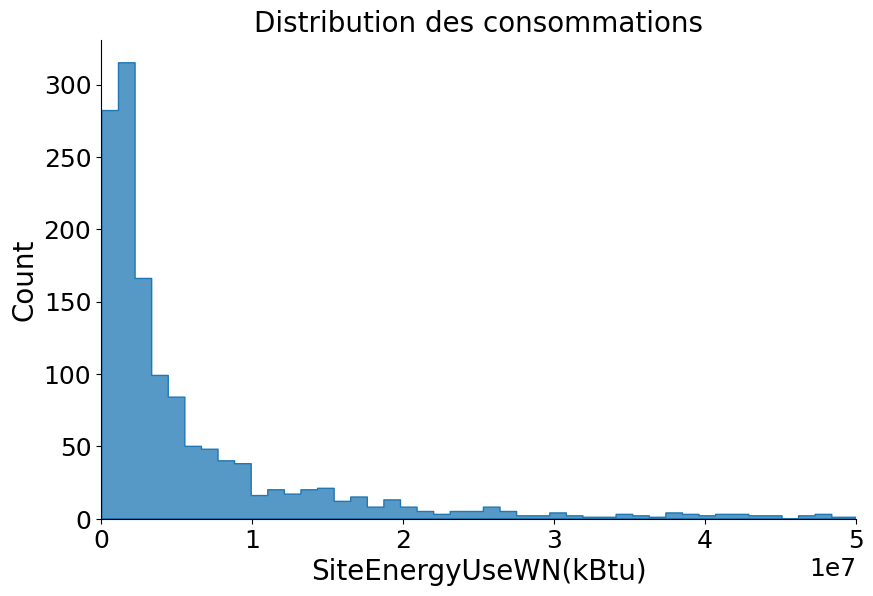

In [132]:
ghg = sns.displot(df_num, x='SiteEnergyUseWN(kBtu)', 
            element="step", 
            height=6, aspect=1.5, log_scale=False)
plt.xlim(0,0.5e8)
ghg.set(title="Distribution des consommations")

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_58595/4096827934.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,0.5e8)


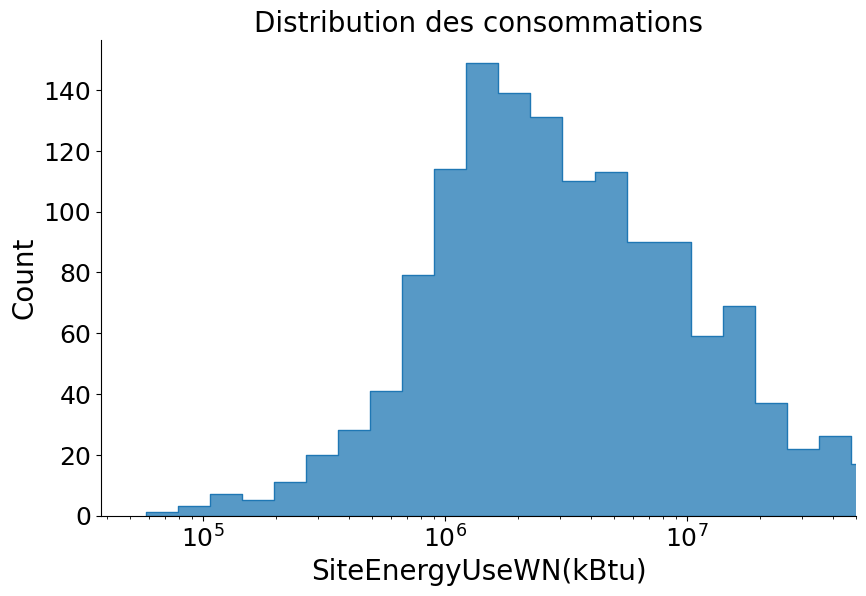

In [133]:
ghg = sns.displot(df_num, x='SiteEnergyUseWN(kBtu)', 
            element="step", 
            height=6, aspect=1.5, log_scale=True)
plt.xlim(0,0.5e8)
ghg.set(title="Distribution des consommations")

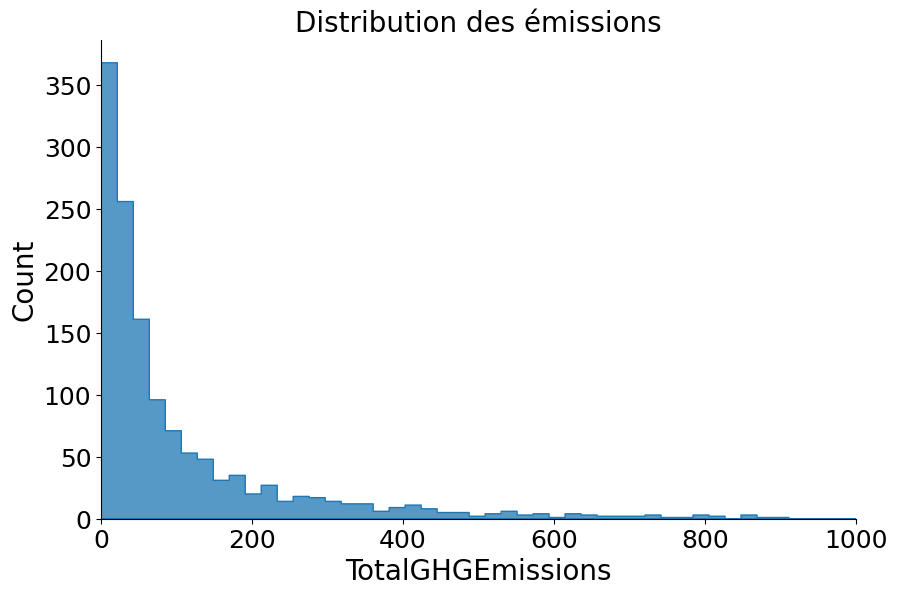

In [134]:
ghg = sns.displot(df_num, x='TotalGHGEmissions',
            element="step", 
            height=6, aspect=1.5, log_scale=False)
plt.xlim(0,1000)
ghg.set(title="Distribution des émissions")

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_58595/1022391291.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1000)


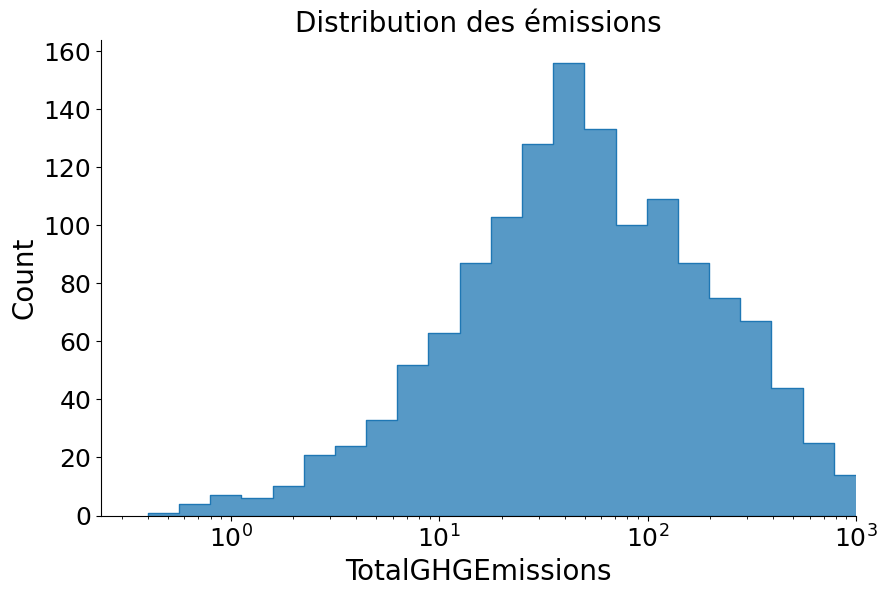

In [135]:
ghg = sns.displot(df_num, x='TotalGHGEmissions',
            element="step", 
            height=6, aspect=1.5, log_scale=True)
plt.xlim(0,1000)
ghg.set(title="Distribution des émissions")

#### 4.6.1 Passage au log

In [136]:
# Prendre le logarithme des variables cibles
df_num['Log_SiteEnergyUseWN(kBtu)'] = np.log(df_num['SiteEnergyUseWN(kBtu)'] + 1)  # +1 pour gérer les valeurs 0
df_num['Log_TotalGHGEmissions'] = np.log(df_num['TotalGHGEmissions'] + 1)

# Afficher les premières lignes pour vérifier
df_num[['Log_SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions']].head()

Log_SiteEnergyUseWN(kBtu)  Log_TotalGHGEmissions
0                  15.824652               5.525373
1                  15.974742               5.693261
2                  18.118725               7.645053
3                  15.753792               5.660979
4                  16.500395               6.226556

## 4.7 Création de df_1 et df_2

#### 4.7.1 Dernières modifications de df_num

In [137]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearBuilt                  1379 non-null   int64  
 1   NumberofBuildings          1379 non-null   float64
 2   NumberofFloors             1379 non-null   int64  
 3   PropertyGFABuilding(s)     1379 non-null   int64  
 4   ENERGYSTARScore            924 non-null    float64
 5   SiteEnergyUseWN(kBtu)      1379 non-null   float64
 6   TotalGHGEmissions          1379 non-null   float64
 7   DistanceToDowntown         1379 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)  1379 non-null   float64
 9   Log_TotalGHGEmissions      1379 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 150.8 KB


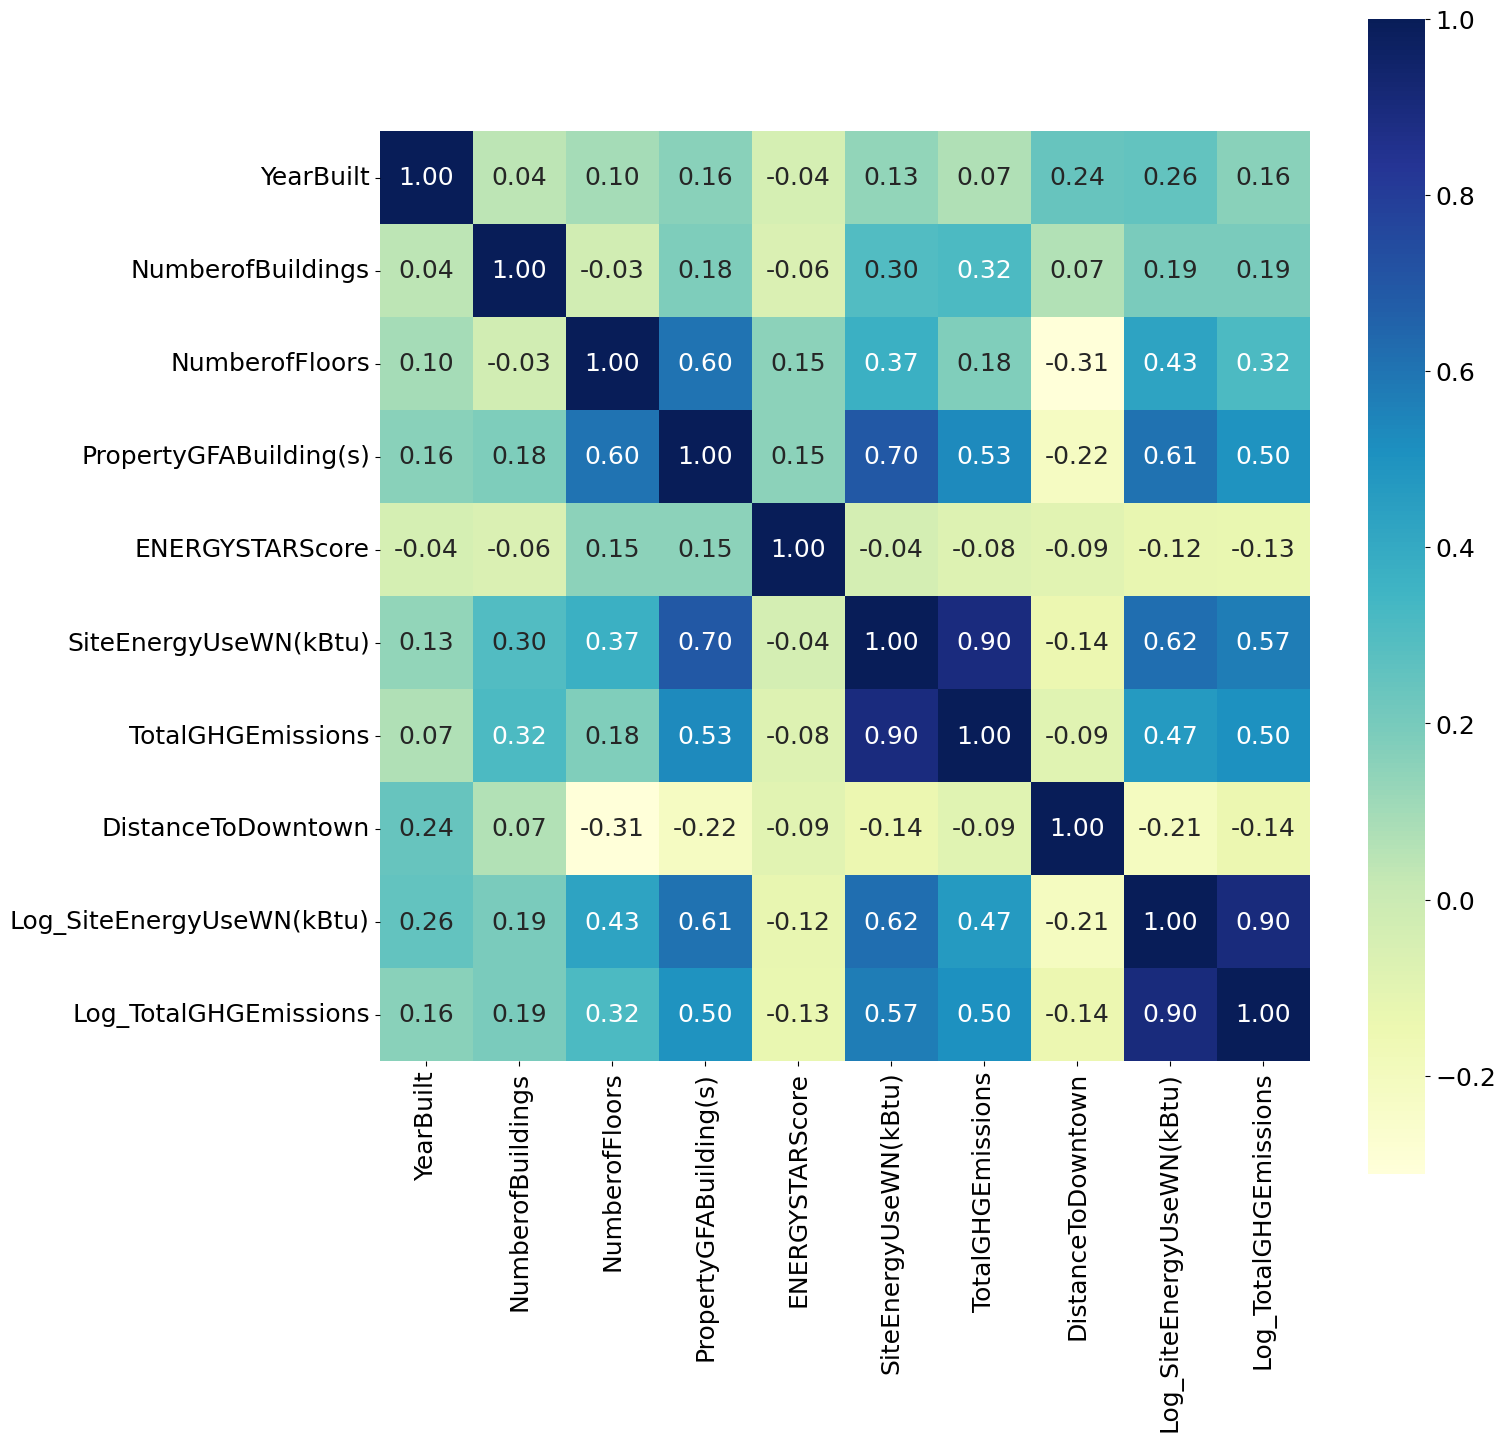

In [138]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_title('Matrice de corrélation', fontdict={'fontsize':18}, x=0.5, y=1.1)

# Create the heatmap
corr_heatmap = sns.heatmap(df_num.corr(), 
                           annot=True, square=True, ax=ax, fmt='.2f', cmap='YlGnBu')

# Modify colorbar label fontsize
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18) # Adjust as needed

plt.show()

#### 4.7.2 Création de df_num_1 et df_num_2

In [139]:
df_num_1 = df_num.drop(columns=['TotalGHGEmissions', 'Log_TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'])
df_num_2 = df_num.drop(columns=['SiteEnergyUseWN(kBtu)', 'Log_SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])

In [140]:
df_num_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearBuilt                  1379 non-null   int64  
 1   NumberofBuildings          1379 non-null   float64
 2   NumberofFloors             1379 non-null   int64  
 3   PropertyGFABuilding(s)     1379 non-null   int64  
 4   ENERGYSTARScore            924 non-null    float64
 5   DistanceToDowntown         1379 non-null   float64
 6   Log_SiteEnergyUseWN(kBtu)  1379 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 118.5 KB


In [141]:
df_num_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   YearBuilt               1379 non-null   int64  
 1   NumberofBuildings       1379 non-null   float64
 2   NumberofFloors          1379 non-null   int64  
 3   PropertyGFABuilding(s)  1379 non-null   int64  
 4   ENERGYSTARScore         924 non-null    float64
 5   DistanceToDowntown      1379 non-null   float64
 6   Log_TotalGHGEmissions   1379 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 118.5 KB


#### 4.7.4 Combinaison de  df_cat_1_encoded et df_cat_2_encoded avec df_num_1_scaled et df_num_2_scaled

In [142]:
# Concatenate the DataFrames horizontally
df_1 = pd.concat([df_cat, df_num_1], axis=1)
df_2 = pd.concat([df_cat, df_num_2], axis=1)

# Specify columns to consider for NaN, excluding 'ENERGYSTARScore'
columns_to_consider_df1 = df_1.columns.drop('ENERGYSTARScore')
columns_to_consider_df2 = df_2.columns.drop('ENERGYSTARScore')

# Drop rows with NaN in these columns
df_1 = df_1.dropna(subset=columns_to_consider_df1)
df_2 = df_2.dropna(subset=columns_to_consider_df2)

In [143]:
df_1.tail()

Neighborhood GroupedPrimaryPropertyTypes  YearBuilt  \
3365                BALLARD            Bâtiments Autres     1972.0   
3367                   EAST            Bâtiments Autres     1912.0   
3370               DELRIDGE            Bâtiments Autres     1982.0   
3372               DOWNTOWN            Bâtiments Autres     2004.0   
3373  MAGNOLIA / QUEEN ANNE            Bâtiments Autres     1974.0   

      NumberofBuildings  NumberofFloors  PropertyGFABuilding(s)  \
3365                1.0             1.0                 12769.0   
3367                1.0             1.0                 23445.0   
3370                1.0             1.0                 18261.0   
3372                1.0             1.0                 16000.0   
3373                1.0             1.0                 13157.0   

      ENERGYSTARScore  DistanceToDowntown  Log_SiteEnergyUseWN(kBtu)  
3365              NaN            8.656403                  15.496388  
3367              NaN            3.315600                  15.720053  
3370              NaN            7.784919                  13.840626  
3372              NaN            1.266886                  13.867825  
3373              NaN            3.940774                  15.616191

In [144]:
df_2.tail()

Neighborhood GroupedPrimaryPropertyTypes  YearBuilt  \
3365                BALLARD            Bâtiments Autres     1972.0   
3367                   EAST            Bâtiments Autres     1912.0   
3370               DELRIDGE            Bâtiments Autres     1982.0   
3372               DOWNTOWN            Bâtiments Autres     2004.0   
3373  MAGNOLIA / QUEEN ANNE            Bâtiments Autres     1974.0   

      NumberofBuildings  NumberofFloors  PropertyGFABuilding(s)  \
3365                1.0             1.0                 12769.0   
3367                1.0             1.0                 23445.0   
3370                1.0             1.0                 18261.0   
3372                1.0             1.0                 16000.0   
3373                1.0             1.0                 13157.0   

      ENERGYSTARScore  DistanceToDowntown  Log_TotalGHGEmissions  
3365              NaN            8.656403               5.380727  
3367              NaN            3.315600               5.561527  
3370              NaN            7.784919               3.060115  
3372              NaN            1.266886               3.501646  
3373              NaN            3.940774               5.414054

In [145]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1379 non-null   object 
 1   GroupedPrimaryPropertyTypes  1379 non-null   object 
 2   YearBuilt                    1379 non-null   float64
 3   NumberofBuildings            1379 non-null   float64
 4   NumberofFloors               1379 non-null   float64
 5   PropertyGFABuilding(s)       1379 non-null   float64
 6   ENERGYSTARScore              924 non-null    float64
 7   DistanceToDowntown           1379 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)    1379 non-null   float64
dtypes: float64(7), object(2)
memory usage: 107.7+ KB


In [146]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 3373
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1379 non-null   object 
 1   GroupedPrimaryPropertyTypes  1379 non-null   object 
 2   YearBuilt                    1379 non-null   float64
 3   NumberofBuildings            1379 non-null   float64
 4   NumberofFloors               1379 non-null   float64
 5   PropertyGFABuilding(s)       1379 non-null   float64
 6   ENERGYSTARScore              924 non-null    float64
 7   DistanceToDowntown           1379 non-null   float64
 8   Log_TotalGHGEmissions        1379 non-null   float64
dtypes: float64(7), object(2)
memory usage: 107.7+ KB


## 6. Feature engineering (AFTER FIRST MODELS)

### 6.1 Proportion de surface parking ?

### 6.2 Proportion de surface bâtiment ?

### 6.3 Proportion de consommation d'électricité ?

TO TRY : 

 - Different quantile te group the PrimaryUseTypes

## 7. Export csv

df_SiteEnergyUseWN 
df_TotalGHGEmissions

In [147]:
path="data/cleaned/"
filename_1="df_SiteEnergyUseWN_0.csv"
filename_2="df_TotalGHGEmissions_0.csv"

In [148]:
df_1.to_csv(path+filename_1, index=False)
df_2.to_csv(path+filename_2, index=False)

## 8. Estimation of the best k-value for KNN imputation

Pour déterminer la meilleure valeur de k pour l'imputation KNN, on va utiliser un DataFrame avec des données complètes pour l'ENERGYSTARScore. On va ensuite masquer une partie de ces données et tester l'efficacité de l'imputation KNN pour différentes valeurs de k. 

In [149]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_columns_df1 = df_1.select_dtypes(include=['object', 'category']).columns
numerical_columns_df1 = df_1.select_dtypes(include=['int64', 'float64']).columns

categorical_columns_df2 = df_2.select_dtypes(include=['object', 'category']).columns
numerical_columns_df2 = df_2.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for one hot encoding and scaling
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine transformers into a preprocessor
preprocessor_df1 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns_df1),
        ('cat', categorical_transformer, categorical_columns_df1)])

preprocessor_df2 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns_df2),
        ('cat', categorical_transformer, categorical_columns_df2)])

# Apply transformations
df1_processed = preprocessor_df1.fit_transform(df_1)
df2_processed = preprocessor_df2.fit_transform(df_2)


In [150]:
# Convert the processed numpy arrays back to pandas DataFrames
# For df1
df1_processed_df = pd.DataFrame(df1_processed, columns = preprocessor_df1.get_feature_names_out())

# For df2
df2_processed_df = pd.DataFrame(df2_processed, columns = preprocessor_df2.get_feature_names_out())

In [151]:
df1_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 27 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   num__YearBuilt                                                            1379 non-null   float64
 1   num__NumberofBuildings                                                    1379 non-null   float64
 2   num__NumberofFloors                                                       1379 non-null   float64
 3   num__PropertyGFABuilding(s)                                               1379 non-null   float64
 4   num__ENERGYSTARScore                                                      924 non-null    float64
 5   num__DistanceToDowntown                                                   1379 non-null   float64
 6   num__Log_SiteEnergyUseWN(kBtu)                                  

In [152]:
def test_knn_imputation(df, variable, max_k=10, iterations=100):
    results = {k: [] for k in range(1, max_k + 1)}
    
    for _ in range(iterations):
        # Créer une copie profonde pour éviter les modifications sur le DataFrame original
        df_test = df.dropna(subset=[variable]).copy()
        
        # Utilisation de .loc pour les assignations
        mask = np.random.rand(len(df_test)) < 0.3
        df_test['masked_var'] = df_test[variable]
        df_test.loc[mask, 'masked_var'] = np.nan

        for k in range(1, max_k + 1):
            imputer = KNNImputer(n_neighbors=k)
            df_imputed = imputer.fit_transform(df_test.drop(columns=[variable]))
            df_imputed = pd.DataFrame(df_imputed, columns=df_test.drop(columns=[variable]).columns)

            mse = mean_squared_error(df_test.loc[mask, variable], df_imputed.loc[mask, 'masked_var'])
            results[k].append(mse)

    # Calculer la moyenne des erreurs pour chaque k
    mean_results = {k: np.mean(mse_list) for k, mse_list in results.items()}
    return mean_results

In [153]:
# Appliquer la fonction sur votre DataFrame (remplacez df_1 par votre DataFrame)
results = test_knn_imputation(df1_processed_df, 'num__ENERGYSTARScore', 30)

# Trier les résultats par erreur (valeur du dictionnaire)
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Afficher les résultats triés
for k, mse in sorted_results:
    print(f"k={k}, MSE={mse}")

k=17, MSE=0.8595488190626739
k=15, MSE=0.8601982414257683
k=24, MSE=0.8602440641115429
k=25, MSE=0.8602655013926954
k=26, MSE=0.8604557699266866
k=18, MSE=0.8604930053302803
k=16, MSE=0.8606324707920692
k=27, MSE=0.8607672468358467
k=14, MSE=0.8608932578668016
k=20, MSE=0.8609482912270708
k=19, MSE=0.8610185132877193
k=21, MSE=0.8611703165659276
k=23, MSE=0.8614228873881626
k=22, MSE=0.8616211956532044
k=28, MSE=0.8620696848915569
k=13, MSE=0.8627775106563003
k=29, MSE=0.8633904007866054
k=30, MSE=0.8644474358447455
k=12, MSE=0.865718357846881
k=11, MSE=0.8696191266083659
k=10, MSE=0.873852870895875
k=9, MSE=0.8779391549530995
k=8, MSE=0.8842144098489904
k=7, MSE=0.8900459872485922
k=6, MSE=0.9051285400804224
k=5, MSE=0.9295119468706866
k=4, MSE=0.9652662370370167
k=3, MSE=1.0281928856479166
k=2, MSE=1.1269189194124267
k=1, MSE=1.3903703421728606


In [154]:
# Appliquer la fonction sur votre DataFrame (remplacez df_1 par votre DataFrame)
results = test_knn_imputation(df2_processed_df, 'num__ENERGYSTARScore', 30)

# Trier les résultats par erreur (valeur du dictionnaire)
sorted_results = sorted(results.items(), key=lambda x: x[1])

# Afficher les résultats triés
for k, mse in sorted_results:
    print(f"k={k}, MSE={mse}")

k=19, MSE=0.8885476398993185
k=20, MSE=0.8887263130588413
k=21, MSE=0.888773813563438
k=22, MSE=0.8887935894417446
k=23, MSE=0.8891703562070384
k=24, MSE=0.8895519041582916
k=27, MSE=0.8896495483866397
k=26, MSE=0.8896979460700013
k=28, MSE=0.8899349505379387
k=18, MSE=0.8900849092530119
k=29, MSE=0.8901686792080008
k=25, MSE=0.8902441140820122
k=30, MSE=0.8905927545016415
k=17, MSE=0.8932800773542239
k=16, MSE=0.8955774853467078
k=15, MSE=0.898017944024178
k=14, MSE=0.8997472064985773
k=13, MSE=0.9030340345702443
k=12, MSE=0.906137428186108
k=11, MSE=0.9138849683404393
k=10, MSE=0.9213157222651569
k=9, MSE=0.9266674536277659
k=8, MSE=0.9340835101714152
k=7, MSE=0.9432380397504242
k=6, MSE=0.9601355956949891
k=5, MSE=0.9823996066996871
k=4, MSE=1.0153445958662726
k=3, MSE=1.0662381416930942
k=2, MSE=1.1831104567471773
k=1, MSE=1.5350162194713506


In [155]:
def test_knn_imputation(df, variable, max_k=10, iterations=100):
    results = {k: {'mse': [], 'relative_error': []} for k in range(1, max_k + 1)}
    
    for _ in range(iterations):
        df_test = df.dropna(subset=[variable]).copy()
        mask = np.random.rand(len(df_test)) < 0.3
        df_test['masked_var'] = df_test[variable]
        df_test.loc[mask, 'masked_var'] = np.nan

        for k in range(1, max_k + 1):
            imputer = KNNImputer(n_neighbors=k)
            df_imputed = imputer.fit_transform(df_test.drop(columns=[variable]))
            df_imputed = pd.DataFrame(df_imputed, columns=df_test.drop(columns=[variable]).columns)

            mse = mean_squared_error(df_test.loc[mask, variable], df_imputed.loc[mask, 'masked_var'])
            relative_error = np.mean(np.abs(df_test.loc[mask, variable] - df_imputed.loc[mask, 'masked_var']) / np.abs(df_test.loc[mask, variable]))

            results[k]['mse'].append(mse)
            results[k]['relative_error'].append(relative_error)

    # Calculer la moyenne et l'écart-type des erreurs pour chaque k
    mean_mse = {k: np.mean(v['mse']) for k, v in results.items()}
    std_mse = {k: np.std(v['mse']) for k, v in results.items()}
    mean_relative_error = {k: np.mean(v['relative_error']) for k, v in results.items()}
    std_relative_error = {k: np.std(v['relative_error']) for k, v in results.items()}

    # Tracer les résultats MSE avec des barres d'erreur
    plt.figure(figsize=(12, 6))
    k_values = list(mean_mse.keys())
    mse_values = list(mean_mse.values())
    mse_stds = list(std_mse.values())

    plt.errorbar(k_values, mse_values, yerr=mse_stds, fmt='-o', capsize=5, label='MSE')
    plt.xlabel('Valeur de k')
    plt.ylabel('MSE Moyenne')
    plt.title('Performance de l\'Imputation KNN pour Différentes Valeurs de k')
    plt.grid(True)
    plt.legend()

    # Tracer les résultats d'erreur relative avec des barres d'erreur
    plt.figure(figsize=(12, 6))
    relative_error_values = list(mean_relative_error.values())
    relative_error_stds = list(std_relative_error.values())
    plt.errorbar(k_values, relative_error_values, yerr=relative_error_stds, fmt='-o', capsize=5, label='Erreur Relative')
    plt.xlabel('Valeur de k')
    plt.ylabel('Erreur Relative Moyenne')
    plt.title('Erreur Relative Moyenne de l\'Imputation KNN pour Différentes Valeurs de k avec Barres d\'Erreur')
    plt.grid(True)
    plt.legend()

    plt.show()

    return mean_mse, std_mse, mean_relative_error


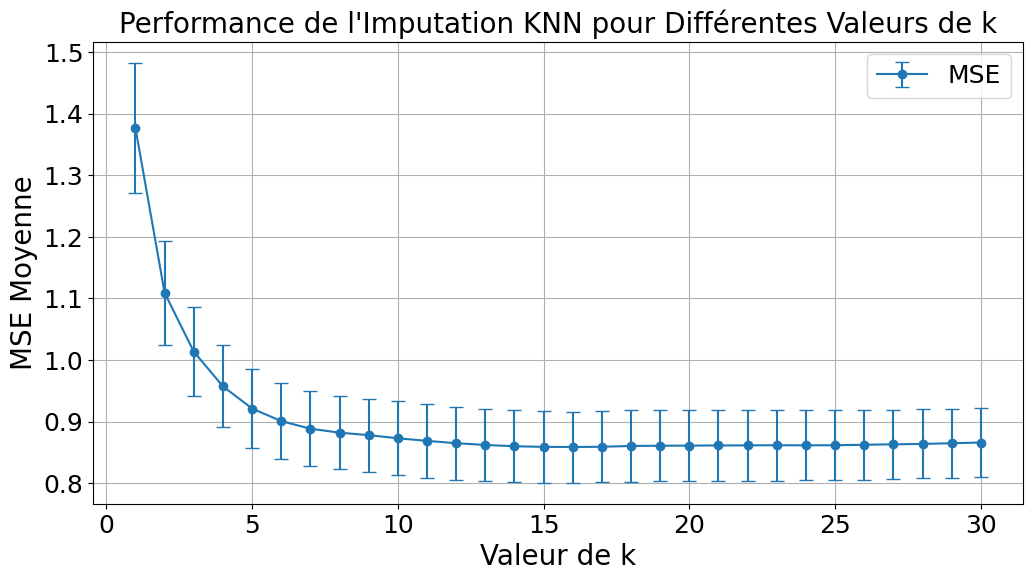

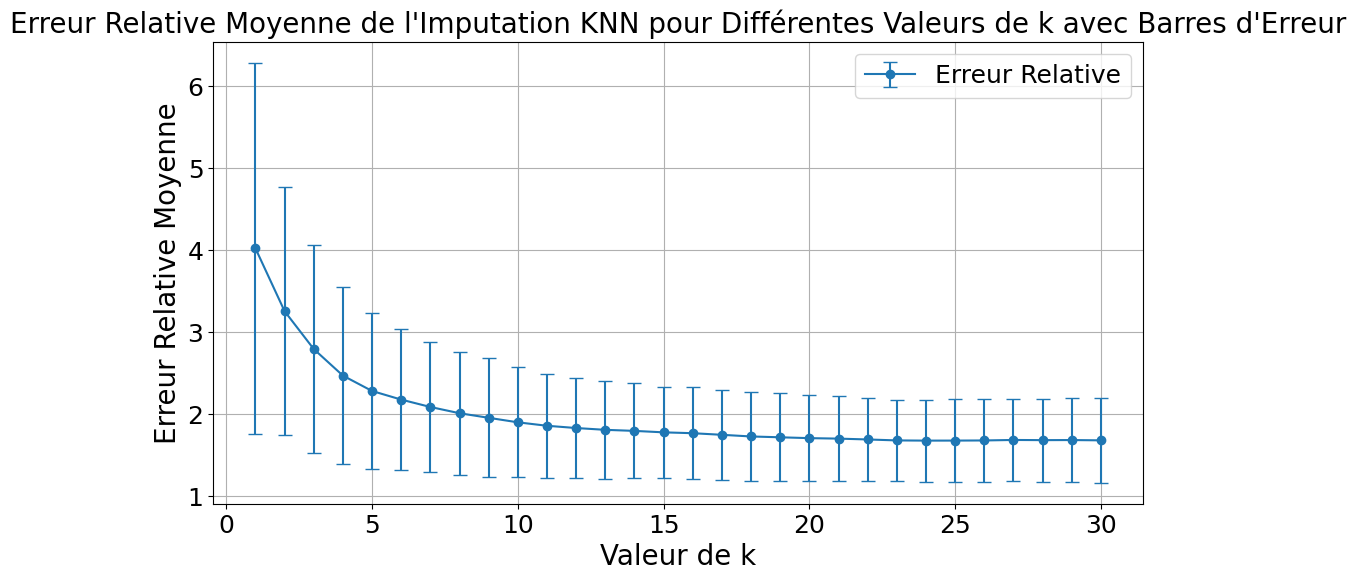

k=16, MSE moyen=0.8587, Écart-type=0.0577, Erreur relative moyenne=1.7707
k=15, MSE moyen=0.8590, Écart-type=0.0583, Erreur relative moyenne=1.7811
k=17, MSE moyen=0.8591, Écart-type=0.0577, Erreur relative moyenne=1.7511
k=14, MSE moyen=0.8600, Écart-type=0.0583, Erreur relative moyenne=1.7989
k=18, MSE moyen=0.8605, Écart-type=0.0580, Erreur relative moyenne=1.7310
k=19, MSE moyen=0.8608, Écart-type=0.0579, Erreur relative moyenne=1.7209
k=20, MSE moyen=0.8610, Écart-type=0.0579, Erreur relative moyenne=1.7106
k=21, MSE moyen=0.8613, Écart-type=0.0574, Erreur relative moyenne=1.7047
k=22, MSE moyen=0.8614, Écart-type=0.0573, Erreur relative moyenne=1.6944
k=24, MSE moyen=0.8615, Écart-type=0.0571, Erreur relative moyenne=1.6804
k=23, MSE moyen=0.8616, Écart-type=0.0574, Erreur relative moyenne=1.6828
k=25, MSE moyen=0.8616, Écart-type=0.0569, Erreur relative moyenne=1.6808
k=13, MSE moyen=0.8621, Écart-type=0.0589, Erreur relative moyenne=1.8118
k=26, MSE moyen=0.8624, Écart-type=0.0

In [156]:
# Appliquer la fonction sur votre DataFrame
# Remplacez df_1 par votre DataFrame
mean_results, std_results, mean_relative_error = test_knn_imputation(df1_processed_df, 'num__ENERGYSTARScore', max_k=30, iterations=500)

# Afficher les résultats triés avec l'écart-type et l'erreur relative
sorted_results = sorted(mean_results.items(), key=lambda x: x[1])
for k, mse in sorted_results:
    std_dev = std_results[k]
    rel_error = mean_relative_error[k]
    print(f"k={k}, MSE moyen={mse:.4f}, Écart-type={std_dev:.4f}, Erreur relative moyenne={rel_error:.4f}")


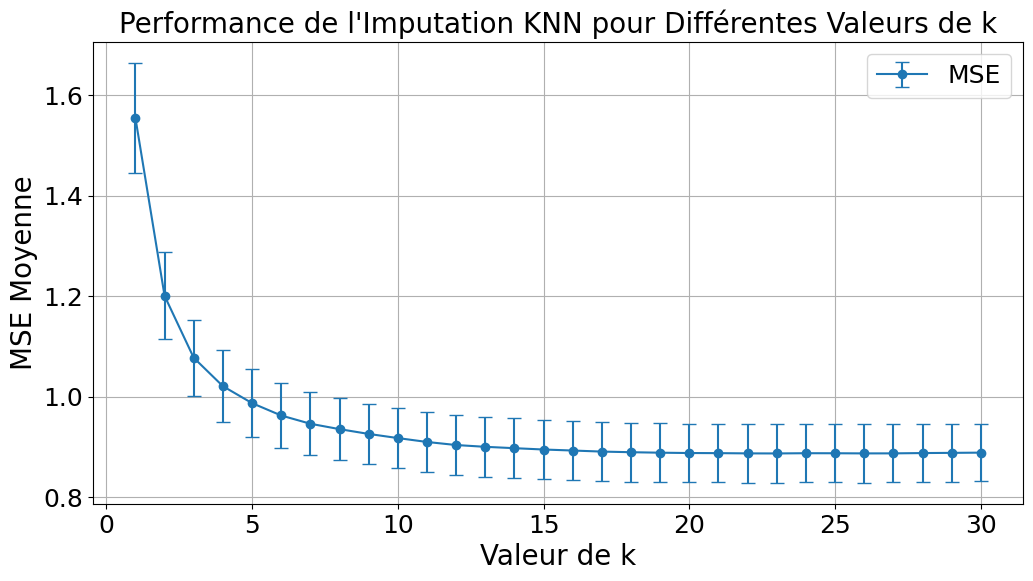

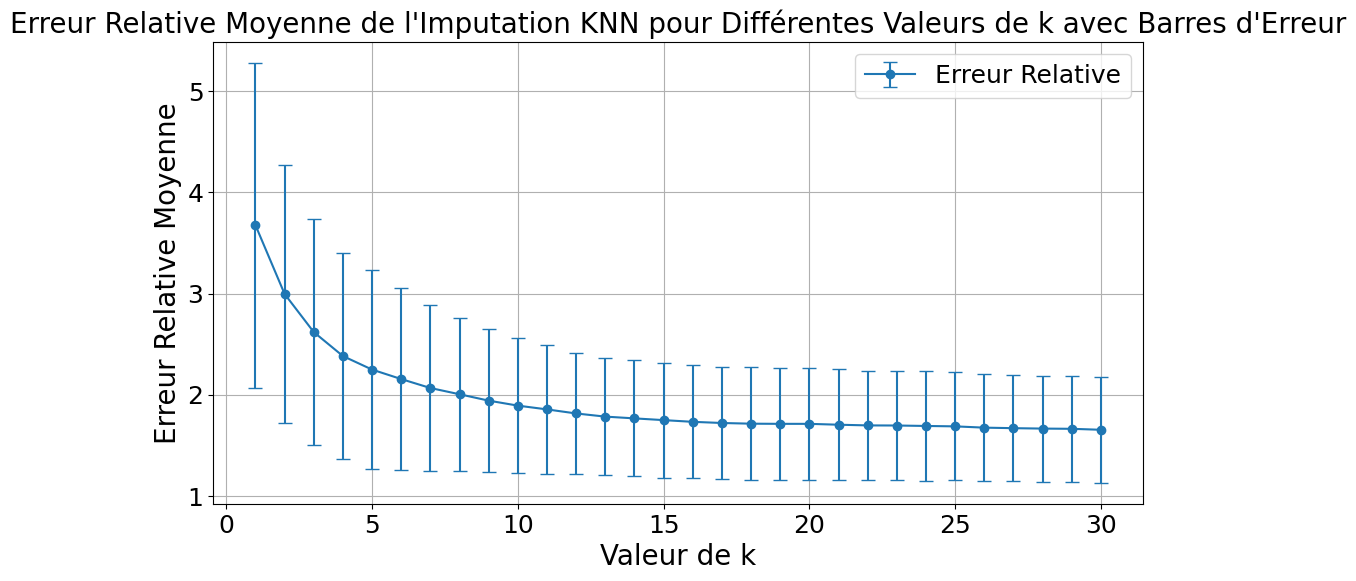

k=23, MSE moyen=0.8874, Écart-type=0.0582, Erreur relative moyenne=1.6972
k=26, MSE moyen=0.8875, Écart-type=0.0580, Erreur relative moyenne=1.6761
k=22, MSE moyen=0.8875, Écart-type=0.0583, Erreur relative moyenne=1.6982
k=27, MSE moyen=0.8876, Écart-type=0.0577, Erreur relative moyenne=1.6709
k=25, MSE moyen=0.8878, Écart-type=0.0581, Erreur relative moyenne=1.6887
k=24, MSE moyen=0.8879, Écart-type=0.0582, Erreur relative moyenne=1.6927
k=21, MSE moyen=0.8880, Écart-type=0.0582, Erreur relative moyenne=1.7050
k=28, MSE moyen=0.8882, Écart-type=0.0575, Erreur relative moyenne=1.6668
k=20, MSE moyen=0.8882, Écart-type=0.0583, Erreur relative moyenne=1.7136
k=29, MSE moyen=0.8886, Écart-type=0.0572, Erreur relative moyenne=1.6646
k=19, MSE moyen=0.8889, Écart-type=0.0585, Erreur relative moyenne=1.7137
k=30, MSE moyen=0.8890, Écart-type=0.0572, Erreur relative moyenne=1.6550
k=18, MSE moyen=0.8899, Écart-type=0.0588, Erreur relative moyenne=1.7152
k=17, MSE moyen=0.8911, Écart-type=0.0

In [157]:
# Appliquer la fonction sur votre DataFrame
# Remplacez df_1 par votre DataFrame
mean_results, std_results, mean_relative_error = test_knn_imputation(df2_processed_df, 'num__ENERGYSTARScore', max_k=30, iterations=500)

# Afficher les résultats triés avec l'écart-type et l'erreur relative
sorted_results = sorted(mean_results.items(), key=lambda x: x[1])
for k, mse in sorted_results:
    std_dev = std_results[k]
    rel_error = mean_relative_error[k]
    print(f"k={k}, MSE moyen={mse:.4f}, Écart-type={std_dev:.4f}, Erreur relative moyenne={rel_error:.4f}")


Une recherche de type validation croisée

In [158]:
def test_knn_imputation_performance(df, variable, k_values, n_splits_values, num_trials, random_seed=42):
    performance = {n_splits: {k: [] for k in k_values} for n_splits in n_splits_values}

    for n_splits in n_splits_values:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        
        for k in k_values:
            for trial in range(num_trials):
                np.random.seed(random_seed + trial)  # Fixer la graine aléatoire pour la cohérence
                mse_values = []
                for train_index, test_index in kf.split(df):
                    train, test = df.iloc[train_index], df.iloc[test_index]
                    test_missing = test.copy()
                    missing_indices = np.random.choice(test.index, size=int(len(test)), replace=False)
                    test_missing.loc[missing_indices, variable] = np.nan

                    imputer = KNNImputer(n_neighbors=k)
                    imputed_values = imputer.fit_transform(pd.concat([train, test_missing]))

                    mse = mean_squared_error(test.loc[missing_indices, variable], imputed_values[-len(missing_indices):, train.columns.get_loc(variable)])
                    mse_values.append(mse)

                performance[n_splits][k].append(np.mean(mse_values))

    # Tracer les résultats
    plt.figure(figsize=(15, 8))

    for n_splits in n_splits_values:
        k_performance = {k: np.mean(mse) for k, mse in performance[n_splits].items()}
        k_std = {k: np.std(mse) for k, mse in performance[n_splits].items()}

        # Trier par performance (MSE)
        sorted_k = sorted(k_performance.items(), key=lambda x: x[1])

        # Afficher les trois meilleures valeurs de k et leurs performances
        best_k_values = sorted_k[:3]
        print(f"Pour n_splits = {n_splits}, les 3 meilleures valeurs de k sont :")
        for k, mse in best_k_values:
            print(f"  k = {k}, MSE moyen = {mse:.4f}, Écart-type = {k_std[k]:.4f}")

        # Tracer les performances pour chaque valeur de k
        means = [k_performance[k] for k in k_values]
        stds = [k_std[k] for k in k_values]  # Calcul de l'écart-type
        plt.errorbar(k_values, means, yerr=stds, label=f'n_splits={n_splits}', fmt='-o', capsize=5)

    plt.xlabel('Valeur de k')
    plt.ylabel('MSE Moyenne')
    plt.title('Performance de l\'Imputation KNN pour Différentes Valeurs de k et n_splits')
    plt.legend()
    plt.grid(True)
    plt.show()

Pour n_splits = 5, les 3 meilleures valeurs de k sont :
  k = 29, MSE moyen = 1.1403, Écart-type = 0.0165
  k = 28, MSE moyen = 1.1436, Écart-type = 0.0166
  k = 27, MSE moyen = 1.1463, Écart-type = 0.0175


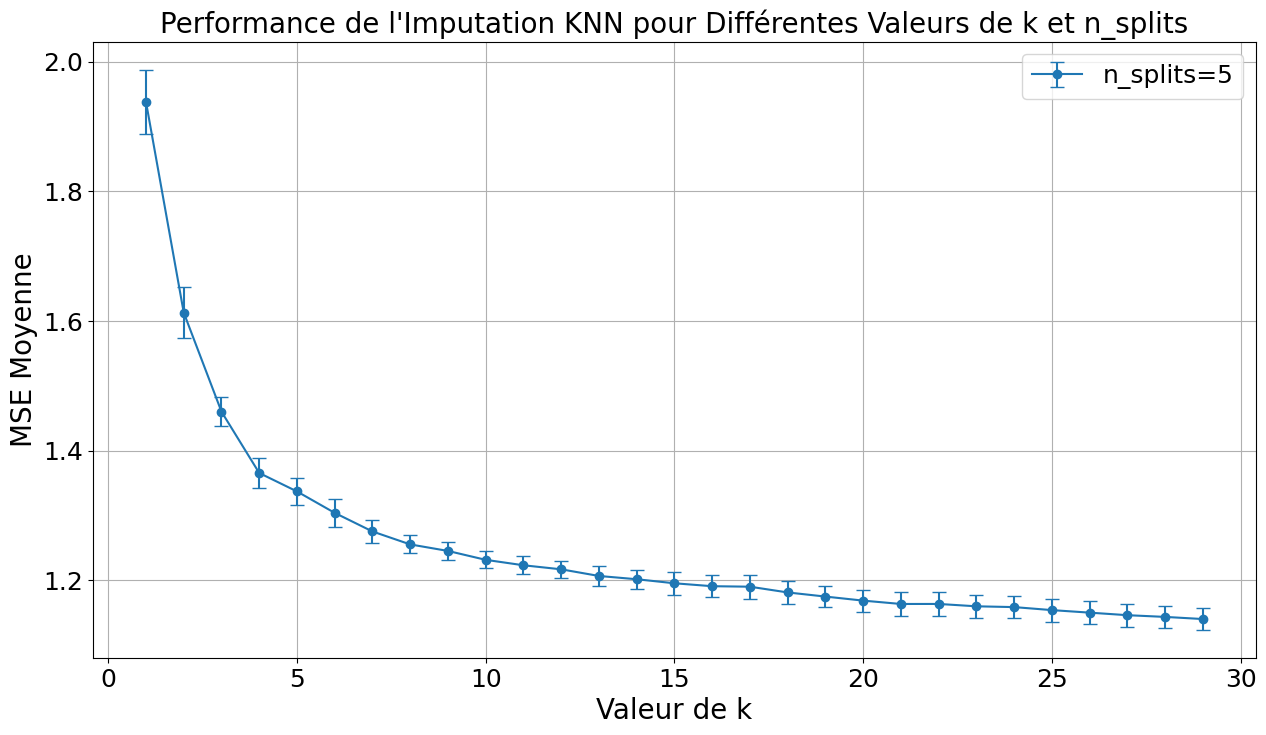

In [159]:
variable = 'num__ENERGYSTARScore'

df_test = df1_processed_df.dropna(subset=[variable]).copy()

k_values = range(1, 30)  # Les valeurs de k à tester
n_splits_values = [5]  # Les valeurs de n_splits pour la validation croisée
num_trials = 10  # Nombre d'essais pour chaque combinaison de k et n_splits

test_knn_imputation_performance(df_test, variable, k_values, n_splits_values, num_trials)

Pour n_splits = 5, les 3 meilleures valeurs de k sont :
  k = 29, MSE moyen = 1.1303, Écart-type = 0.0158
  k = 28, MSE moyen = 1.1331, Écart-type = 0.0162
  k = 27, MSE moyen = 1.1352, Écart-type = 0.0164


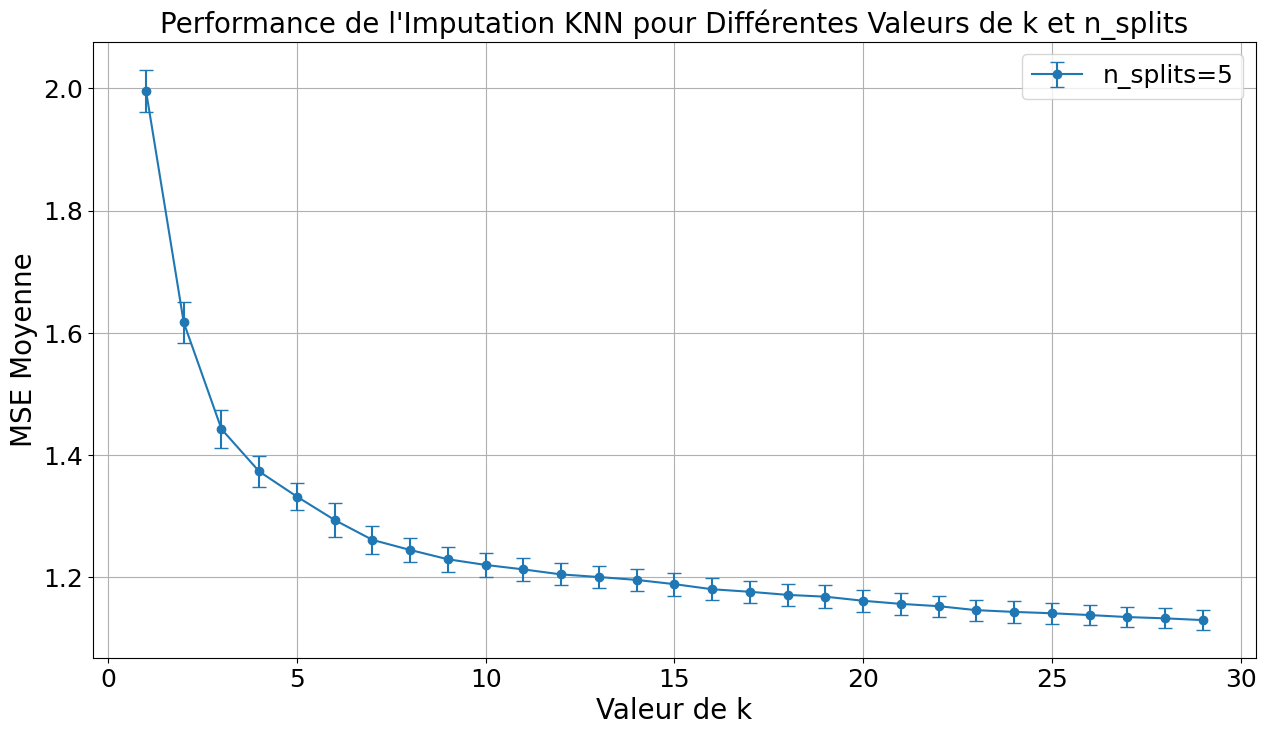

In [160]:
variable = 'num__ENERGYSTARScore'

df_test = df2_processed_df.dropna(subset=[variable]).copy()

k_values = range(1, 30)  # Les valeurs de k à tester
n_splits_values = [5]  # Les valeurs de n_splits pour la validation croisée
num_trials = 10  # Nombre d'essais pour chaque combinaison de k et n_splits

test_knn_imputation_performance(df_test, variable, k_values, n_splits_values, num_trials)